In [0]:
!pip install -U -q PyDrive

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt

#from google.colab import auth
#from oauth2client.client import GoogleCredentials

#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
from scipy import stats

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")

from IPython.display import display

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1WEGaXOBpqAoZ84QEu9DaVVCGgwDmS5Di' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  fname = os.path.join(local_download_path, f['title'])
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


# Load Dataset 5th

In [2]:
submissions_df = pd.DataFrame()

files = ['2017-5to-grado.json']
for file in files:
  json_file = open('./datasets/MumukiPrimaria/'+str(file), encoding='utf8')
  json_data = json.load(json_file)
  submissions = pd.io.json.json_normalize(
      json_data, 'submissions', [['guide','slug'], ['student','email'],['guide','name'], ['exercise','name'],['exercise','eid'],['guide','language','name']], record_prefix='submissions_', errors='ignore')
  submissions_df = submissions_df.append(submissions)

  
submissions_df.shape


(3514, 16)

### Cleaning dataset
Drop submissions that belongs to haskell exercises. And the submissions that belong to the following exercises

* Escribiendo procedimientos
* Un programa un poco largo 	
* El Tablero 
* Sacar con miedo, segundo intento 
* El Cabezal 	
* Las cosas por su nombre 

Because these exercises doesn't need code to be passed.

In [3]:
# Discard Escribiendo procedimientos, un programa un poco largo y las cosas por sus nombre porque son ejercicios de la guia de procedimientos
# Descartamos El tablero, El Cabezal y Sacar con miedo, segundo intento porque no requieren codigo.

submissions_expanded = submissions_df[submissions_df['guide.language.name'].str.contains('gobstone')]
submissions_expanded = submissions_expanded.drop(
    submissions_expanded[(submissions_expanded['exercise.name'] == 'Escribiendo procedimientos') |
                         (submissions_expanded['exercise.name'] == 'Un programa un poco largo') |
                         (submissions_expanded['exercise.name'] == 'El Tablero') |
                         (submissions_expanded['exercise.name'] == 'Sacar con miedo, segundo intento') |
                         (submissions_expanded['exercise.name'] == 'El Cabezal') |
                         (submissions_expanded['exercise.name'] == 'Las cosas por su nombre') 
                        ].index)
submissions_expanded.shape

(3326, 16)

In [4]:
submissions_mantovani = submissions_expanded[submissions_expanded['student.email'].str.contains('@mantovani')]
submissions_mantovani = submissions_mantovani[~(submissions_mantovani['student.email'] == 'prueba@mantovani.edu.ar')]
submissions_mantovani.shape



(1645, 16)

In [5]:
submissions_nsdelvalle = submissions_expanded[submissions_expanded['student.email'].str.contains('@nsdelvalle')]
submissions_nsdelvalle.shape

(1675, 16)

In [6]:
manto_students = len(submissions_mantovani['student.email'].unique())
nsdv_students = len(submissions_nsdelvalle['student.email'].unique())
print("Matovani Students {} \nNuestra senho.. Students {}".format(manto_students, nsdv_students))

Matovani Students 37 
Nuestra senho.. Students 31


# Some info about Dataset

- Whole dataset 3514 submissions
- Total amount of submissions 3326 (discarding exercises that not involve coding)


+ Mantovani sumbmissions amount 1651
+ Nuestra senhora del valle submissions amount 1675


- Mantovani Students 37 (two registered emails are prueba@manto.. and prueba@mantovani.. discard this) 
- NSDV Students 31

In [7]:
def clean_submissions(submissions_df, status_column, content_column='content', to_train=False):
    """
    submissions_df: Dataframe with submissions
    to_train: indicate if dataframe will be use for training
    content_column: column that show content of student submission
    status_column: column that show status of student submission

    Function to cleaning dataset
    """
    submissions_df = submissions_df[~(submissions_df[status_column] == 'aborted')]
    submissions_df = submissions_df[~(submissions_df[status_column] == 'pending')]
    submissions_df = submissions_df[~(submissions_df[status_column] == 'running')]
    submissions_df = submissions_df[~(submissions_df[status_column] == 'manual_evaluation_pending')]
    
    
    if to_train:
            submissions_df = submissions_df[submissions_df[content_column] != ""]
            submissions_df = submissions_df[~submissions_df[content_column].isnull()]
    return submissions_df


def calculate_distribution(df, column_name, exercise, mean=True):
    """
    df: Dataframe with submissions
    column_name: column with status

    Function to obtain distribution of submissions status
    return metrics and amount of submissions
    """
    total_amount_submissions = df.shape[0]
    submissions_grouped = df.groupby([column_name]).size()
    metrics = {}
    if mean:
      metrics = submissions_grouped #


    else:
      metrics = submissions_grouped
    metrics['exercise'] = str(exercise)
    metrics['submission_amount'] = total_amount_submissions
    return metrics


# Exercises Solved by two schools

In [8]:
exer_man = submissions_mantovani['exercise.name'].nunique()
exer_nsdv = submissions_nsdelvalle['exercise.name'].nunique()

print("Exercises solved \n Mant {} \n NSDV {}".format(exer_man, exer_nsdv))
exer = list(set(submissions_mantovani['exercise.name'].unique()).intersection(set(submissions_nsdelvalle['exercise.name'].unique())))
print("{} \n amount exercises {}".format(exer, len(exer)))

exer_excluded = set(submissions_nsdelvalle['exercise.name'].unique()).difference(set(submissions_mantovani['exercise.name'].unique()))
print("{} is the only exercises solved by NSDV but not fot Manto students".format(exer_excluded))

Exercises solved 
 Mant 39 
 NSDV 40
['¿Dónde está el error?', 'Portugal', 'Sacar Bolitas', 'El orden de las cosas', 'La Bandera de Perú', 'Movimientos 2', 'Movimientos 3', 'Cuando no hay bolitas', 'Reemplazar bolitas', 'Diagonal "pesada"', 'Un tablero de luces', 'Un ejemplo medio rebuscado', 'MoverOeste5 usando repeat', 'Y claro, no podía faltar Argentina', 'Limpiando el jardín', 'Repitiendo varios comandos', 'La Bandera de Paraguay', 'Eliminando la bolita roja', 'Sacar con miedo', 'También vale después', 'Combinando comandos', 'Una escalerita', 'Cómo decirle que no...', 'No todo es repetir', 'Bolitas', 'Dos caminos distintos', 'Diagonal con una bolita', 'Calentando motores', 'El caso borde', 'Limpiar celda', 'Un poquito de matemática', 'Sí, esto también se puede romper', 'Bolitas 3', 'Combinando comandos 2', 'Movimientos', 'La computadora repite por nosotros', '¿Y sólo sirve para ver si hay bolitas?', 'MoverOeste10', 'Bolitas 2'] 
 amount exercises 39
{'Enseñándole tareas a la comput

# Submissions distribution by status


Because an error in mumuki.io, discard submission of "La Bandera de paraguay" that was passed.

In [9]:
submission_manto_cleaned = clean_submissions(submissions_mantovani, 'submissions_status')
submission_manto_cleaned = submission_manto_cleaned.drop(submission_manto_cleaned[submission_manto_cleaned['exercise.name'].str.contains('La Bandera de Paraguay') & submission_manto_cleaned['student.email'].str.contains('lautaro.guzman@mantovani.edu.ar')].iloc[1:,:].index)
calculate_distribution(submission_manto_cleaned, 'submissions_status', 'Mantovani Submissions')

submissions_status
errored                                   305
failed                                    555
passed                                    614
passed_with_warnings                        3
exercise                Mantovani Submissions
submission_amount                        1477
dtype: object

In [10]:
submission_nsdelvalle_cleaned = clean_submissions(submissions_nsdelvalle, 'submissions_status')
#submission_nsdelvalle_cleaned = submission_nsdelvalle_cleaned[~(submission_nsdelvalle_cleaned['exercise.name'] == 'Enseñándole tareas a la computadora')]
calculate_distribution(submission_nsdelvalle_cleaned, 'submissions_status', 'Nsdel Valle Submissions')

submissions_status
errored                                     385
failed                                      648
passed                                      629
passed_with_warnings                         10
exercise                Nsdel Valle Submissions
submission_amount                          1672
dtype: object

In [11]:

def calculate_distribution_by_exercise(submissions_df, list_of_exercises, status_column, mean=True):
  distribution_df = pd.DataFrame(columns=['exercise', 'errored', 'failed', 'passed', 'passed_with_warnings', 'submission_amount'])
  for exercise in list_of_exercises:
    exercise_submissions = submissions_df[submissions_df['exercise.name'] == str(exercise)]
    metrics = calculate_distribution(exercise_submissions, status_column, exercise, mean)
    #distribution_df.loc[len(distribution_df)+1] = metrics
    distribution_df = distribution_df.append(metrics, ignore_index=True)
    
  return distribution_df

In [12]:
exercises_nsdelvalle = submission_nsdelvalle_cleaned['exercise.name'].unique()
distribution_nsdelvalle = calculate_distribution_by_exercise(submission_nsdelvalle_cleaned, exercises_nsdelvalle, 'submissions_status')

In [13]:
exercises_manto = submission_manto_cleaned['exercise.name'].unique()
distribution_manto = calculate_distribution_by_exercise(submission_manto_cleaned, exercises_manto, 'submissions_status').sort_values('submission_amount', ascending=False)


In [14]:
result = pd.merge(distribution_nsdelvalle, distribution_manto, on='exercise', suffixes =('_ns', '_man'), how='outer')

result.reindex_axis(
    ['exercise', 'errored_man', 'errored_ns', 'failed_man', 'failed_ns', 'passed_man', 'passed_ns', 'passed_with_warnings_man', 'passed_with_warnings_ns', 'submission_amount_man', 'submission_amount_ns'], axis=1)

,exercise,errored_man,errored_ns,failed_man,failed_ns,passed_man,passed_ns,passed_with_warnings_man,passed_with_warnings_ns,submission_amount_man,submission_amount_ns
0,Sacar con miedo,NaN,NaN,NaN,NaN,2,3,NaN,NaN,2,3
1,Eliminando la bolita roja,NaN,11,NaN,15,2,3,NaN,NaN,2,29
2,Un ejemplo medio rebuscado,5,2,2,1,2,2,NaN,NaN,9,5
3,¿Y sólo sirve para ver si hay bolitas?,11,21,2,5,1,2,NaN,NaN,14,28
4,Cómo decirle que no...,1,13,2,10,1,1,NaN,NaN,4,24
5,Un poquito de matemática,1,5,1,NaN,1,2,NaN,NaN,3,7
6,Dos caminos distintos,NaN,NaN,NaN,NaN,1,1,NaN,NaN,1,1
7,Un tablero de luces,1,2,3,1,1,1,NaN,NaN,5,4
8,Calentando motores,5,1,1,3,31,33,NaN,NaN,37,37
9,Combinando comandos,8,14,30,27,26,28,NaN,NaN,64,69


# Mean Submissions and student by exercise 
By default, mumuki save first submit as submit 0, so for calculate mean we have add one to all submissions count. Then the first submissions would be 1 instead of 0.

In [15]:
submission_manto_cleaned['submissions_submissions_count'] = submission_manto_cleaned['submissions_submissions_count'] +1
submission_nsdelvalle_cleaned['submissions_submissions_count'] = submission_nsdelvalle_cleaned['submissions_submissions_count'] +1 

# Students per exercise

In [16]:
submission_manto_cleaned.groupby(['student.email', 'exercise.name'])['submissions_submissions_count'].count().to_frame().shape

(607, 1)

In [17]:
students_manto = submission_manto_cleaned.groupby(['exercise.name'])['student.email'].nunique().reset_index(name='students_man')
students_manto.rename(columns={'exercise.name': 'exercise'}, inplace=True)
students_manto

,exercise,students_man
0,Bolitas,28
1,Bolitas 2,28
2,Bolitas 3,29
3,Calentando motores,29
4,Combinando comandos,26
5,Combinando comandos 2,25
6,Cuando no hay bolitas,28
7,Cómo decirle que no...,1
8,"Diagonal ""pesada""",5
9,Diagonal con una bolita,7


In [18]:
students_nsdv = submission_nsdelvalle_cleaned.groupby(['exercise.name'])['student.email'].nunique().reset_index(name='students_ns')
students_nsdv.rename(columns={'exercise.name': 'exercise'}, inplace=True)
students_nsdv

,exercise,students_ns
0,Bolitas,31
1,Bolitas 2,31
2,Bolitas 3,31
3,Calentando motores,28
4,Combinando comandos,27
5,Combinando comandos 2,26
6,Cuando no hay bolitas,31
7,Cómo decirle que no...,2
8,"Diagonal ""pesada""",6
9,Diagonal con una bolita,7


In [19]:
result = pd.merge(result, students_manto, on='exercise', how='outer')
result = pd.merge(result, students_nsdv, on='exercise', how='outer')


In [20]:

result = result.reindex_axis(
    ['exercise', 'errored_man', 'errored_ns', 'failed_man', 'failed_ns', 'passed_man', 'passed_ns', 'passed_with_warnings_man', 'passed_with_warnings_ns', 'submission_amount_man', 'students_man', 'submission_amount_ns', 'students_ns'], axis=1)

data_complete = result
result


,exercise,errored_man,errored_ns,failed_man,failed_ns,passed_man,passed_ns,passed_with_warnings_man,passed_with_warnings_ns,submission_amount_man,students_man,submission_amount_ns,students_ns
0,Sacar con miedo,NaN,NaN,NaN,NaN,2,3,NaN,NaN,2,2.0,3,3
1,Eliminando la bolita roja,NaN,11,NaN,15,2,3,NaN,NaN,2,2.0,29,3
2,Un ejemplo medio rebuscado,5,2,2,1,2,2,NaN,NaN,9,2.0,5,3
3,¿Y sólo sirve para ver si hay bolitas?,11,21,2,5,1,2,NaN,NaN,14,2.0,28,2
4,Cómo decirle que no...,1,13,2,10,1,1,NaN,NaN,4,1.0,24,2
5,Un poquito de matemática,1,5,1,NaN,1,2,NaN,NaN,3,1.0,7,2
6,Dos caminos distintos,NaN,NaN,NaN,NaN,1,1,NaN,NaN,1,1.0,1,1
7,Un tablero de luces,1,2,3,1,1,1,NaN,NaN,5,1.0,4,1
8,Calentando motores,5,1,1,3,31,33,NaN,NaN,37,29.0,37,28
9,Combinando comandos,8,14,30,27,26,28,NaN,NaN,64,26.0,69,27


In [21]:
result['mean_sub_man'] = result['submission_amount_man'] / result['students_man']
result['mean_sub_ns'] = result['submission_amount_ns'] / result['students_ns']

## List of mumuki exercises in order of appearance



In [22]:
#Commented elements are exercises that not involve coding
exercises_io = [
    #'El Tablero',
    #'El Cabezal',
    'Movimientos',
    'Movimientos 2',
    'Movimientos 3',
    'El orden de las cosas',
    'Sí, esto también se puede romper',
    'Bolitas',
    'Bolitas 2',
    'Bolitas 3',
    'Sacar Bolitas',
    'Cuando no hay bolitas',
    'Limpiar celda',
    'Calentando motores',
    'Combinando comandos',
    'Combinando comandos 2',
    'Una escalerita',
    'Portugal',
    'Y claro, no podía faltar Argentina',
    'La Bandera de Paraguay',
    'Limpiando el jardín',
    'Reemplazar bolitas',
    'La Bandera de Perú',
    'MoverOeste10',
    'La computadora repite por nosotros',
    'MoverOeste5 usando repeat',
    'No todo es repetir',
    'También vale después',
    'Repitiendo varios comandos',  
    '¿Dónde está el error?',    
    'Diagonal con una bolita',
    'Diagonal "pesada"',
    'El caso borde',  
    'Sacar con miedo',
    #'Sacar con miedo, segundo intento',
    'Eliminando la bolita roja',
    'Un ejemplo medio rebuscado',
    '¿Y sólo sirve para ver si hay bolitas?',
    'Un poquito de matemática',
    'Cómo decirle que no...',
    'Dos caminos distintos',
    'Un tablero de luces',
]

### Re index table with exercise column as index and reorder it in order of appearance

In [23]:
result = result.set_index('exercise')
result = result.reindex(exercises_io)
result


,errored_man,errored_ns,failed_man,failed_ns,passed_man,passed_ns,passed_with_warnings_man,passed_with_warnings_ns,submission_amount_man,students_man,submission_amount_ns,students_ns,mean_sub_man,mean_sub_ns
exercise,,,,,,,,,,,,,,
Movimientos,59,24,NaN,1,36,31,NaN,NaN,95,34.0,56,31,2.79412,1.80645
Movimientos 2,34,31,10,34,31,31,NaN,NaN,75,32.0,96,31,2.34375,3.09677
Movimientos 3,25,20,12,10,33,32,NaN,NaN,70,31.0,62,31,2.25806,2
El orden de las cosas,5,12,10,9,30,32,NaN,NaN,45,30.0,53,31,1.5,1.70968
"Sí, esto también se puede romper",20,8,6,5,33,31,NaN,NaN,59,30.0,44,31,1.96667,1.41935
Bolitas,4,20,7,18,29,32,NaN,NaN,40,28.0,70,31,1.42857,2.25806
Bolitas 2,5,5,1,3,31,32,NaN,NaN,37,28.0,40,31,1.32143,1.29032
Bolitas 3,6,18,14,18,29,31,NaN,NaN,49,29.0,67,31,1.68966,2.16129
Sacar Bolitas,6,12,65,132,28,30,NaN,NaN,99,29.0,174,31,3.41379,5.6129


In [24]:
result.index

Index(['Movimientos', 'Movimientos 2', 'Movimientos 3',
       'El orden de las cosas', 'Sí, esto también se puede romper', 'Bolitas',
       'Bolitas 2', 'Bolitas 3', 'Sacar Bolitas', 'Cuando no hay bolitas',
       'Limpiar celda', 'Calentando motores', 'Combinando comandos',
       'Combinando comandos 2', 'Una escalerita', 'Portugal',
       'Y claro, no podía faltar Argentina', 'La Bandera de Paraguay',
       'Limpiando el jardín', 'Reemplazar bolitas', 'La Bandera de Perú',
       'MoverOeste10', 'La computadora repite por nosotros',
       'MoverOeste5 usando repeat', 'No todo es repetir',
       'También vale después', 'Repitiendo varios comandos',
       '¿Dónde está el error?', 'Diagonal con una bolita', 'Diagonal "pesada"',
       'El caso borde', 'Sacar con miedo', 'Eliminando la bolita roja',
       'Un ejemplo medio rebuscado', '¿Y sólo sirve para ver si hay bolitas?',
       'Un poquito de matemática', 'Cómo decirle que no...',
       'Dos caminos distintos', 'Un tabler

# Define excercises by guide
In the next cell define one dictionary for each guide which contains exercise names in order of appearance. The main objetive here is analyze user performance throughout guides.

In [25]:
guide_1 = {
    1: 'El Tablero',
    2: 'El Cabezal',
    3: 'Movimientos',
    4: 'Movimientos 2',
    5: 'Movimientos 3',
    6: 'El orden de las cosas',
    7: 'Sí, esto también se puede romper',
    8: 'Bolitas',
    9: 'Bolitas 2',
    10: 'Bolitas 3',
    11: 'Sacar Bolitas',
    12: 'Cuando no hay bolitas',
    13: 'Limpiar celda',
}

guide_2 = {
    1: 'Calentando motores',
    2: 'Combinando comandos',
    3: 'Combinando comandos 2',
    4: 'Una escalerita',
    5: 'Portugal',
    6: 'Y claro, no podía faltar Argentina',
    7: 'La Bandera de Paraguay',
    8: 'Limpiando el jardín',
    9: 'Reemplazar bolitas',
    10: 'La Bandera de Perú',
}

guide_3 = {
    1: 'MoverOeste10',
    2: 'La computadora repite por nosotros',
    3: 'MoverOeste5 usando repeat',
    4: 'No todo es repetir',
    5: 'También vale después',
    6: 'Repitiendo varios comandos',  
    7: '¿Dónde está el error?',    
    8: 'Diagonal con una bolita',
    9: 'Diagonal "pesada"',
    10: 'El caso borde',  
}


guide_4 = {
    1: 'Sacar con miedo',
    2: 'Sacar con miedo, segundo intento',
    3: 'Eliminando la bolita roja',
    4: 'Un ejemplo medio rebuscado',
    5: '¿Y sólo sirve para ver si hay bolitas?',
    6: 'Un poquito de matemática',
    7: 'Cómo decirle que no...',
    8: 'Dos caminos distintos',
    9: 'Un tablero de luces',
}


## Define plot function

In [26]:
def plot_realtion_submission_performance(dist_dataframe0, dist_dataframe1, guide_number):
    fig, axes = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)
    fig.subplots_adjust(left=0.2, wspace=0.2, hspace=0.5)
    font = {'family': 'serif',
            'color':  'Black',
            'weight': 'normal',
            'size': 18,
            }

    ax0, ax1 = axes.flatten()
    ax0.set_ylim([0,1.1])
    ax1.set_ylim([0,1.1])
    ax0.set_title('Exercises Distribution Guide '+str(guide_number)+' (Mantovani)', fontdict=font)
    ax1.set_title('Exercises Distribution Guide '+str(guide_number)+' (NSDV)', fontdict=font)

    ax0.plot(dist_dataframe0.index,
             dist_dataframe0['passed'].astype(float), 'o-', color='lime', label='passed',markersize=10)

    ax0.plot(dist_dataframe0.index,
             dist_dataframe0['errored'].astype(float), '*-', color='r', label='errored',markersize=10)

    ax0.plot(dist_dataframe0.index,
             dist_dataframe0['failed'].astype(float), '^-', color='y', label='failed',markersize=10)


    ax1.plot(dist_dataframe1.index,
             dist_dataframe1['passed'].astype(float), 'o-', color='lime', label='passed',markersize=10)

    ax1.plot(dist_dataframe1.index,
             dist_dataframe1['errored'].astype(float), '*-', color='r', label='errored',markersize=10)

    ax1.plot(dist_dataframe1.index,
             dist_dataframe1['failed'].astype(float), '^-', color='y', label='failed',markersize=10)
    
    legend = ax0.legend(shadow=True, fontsize='large', fancybox=True,
        prop={'size': 10}, frameon=True, ncol=1, markerscale=1)
    legend.get_frame().set_facecolor('white')

    legend = ax1.legend(shadow=True, fontsize='large', fancybox=True,
        prop={'size': 10}, frameon=True, ncol=1, markerscale=1)
    legend.get_frame().set_facecolor('white')

    

    ax0.tick_params(axis='x', labelsize=15)
    ax0.tick_params(axis='y', labelsize=15)

    ax0.set_xlabel('Exercise Index', fontsize=15)
    ax1.set_xlabel('Exercise Index', fontsize=15)

    ax1.tick_params(axis='x', labelsize=15)
    ax1.tick_params(axis='y', labelsize=15)

# Analyze by Guide

## Guide 1
In section below, we compare performance between Mantonvani Students and Nuestra senhora del Valle in guide 1.


In [27]:
guide_1_manto = calculate_distribution_by_exercise(submission_manto_cleaned, guide_1.values(), 'submissions_status')
guide_1_nds = calculate_distribution_by_exercise(submission_nsdelvalle_cleaned, guide_1.values(), 'submissions_status')
print('Guide 1 Mantovani')
display(guide_1_manto)
print('\n\n Guide 1 Nuestra senhora del valle')
display(guide_1_nds)


Guide 1 Mantovani


,exercise,errored,failed,passed,passed_with_warnings,submission_amount
0,El Tablero,NaN,NaN,NaN,NaN,0
1,El Cabezal,NaN,NaN,NaN,NaN,0
2,Movimientos,59,NaN,36,NaN,95
3,Movimientos 2,34,10,31,NaN,75
4,Movimientos 3,25,12,33,NaN,70
5,El orden de las cosas,5,10,30,NaN,45
6,"Sí, esto también se puede romper",20,6,33,NaN,59
7,Bolitas,4,7,29,NaN,40
8,Bolitas 2,5,1,31,NaN,37
9,Bolitas 3,6,14,29,NaN,49




 Guide 1 Nuestra senhora del valle


,exercise,errored,failed,passed,passed_with_warnings,submission_amount
0,El Tablero,NaN,NaN,NaN,NaN,0
1,El Cabezal,NaN,NaN,NaN,NaN,0
2,Movimientos,24,1,31,NaN,56
3,Movimientos 2,31,34,31,NaN,96
4,Movimientos 3,20,10,32,NaN,62
5,El orden de las cosas,12,9,32,NaN,53
6,"Sí, esto también se puede romper",8,5,31,NaN,44
7,Bolitas,20,18,32,NaN,70
8,Bolitas 2,5,3,32,NaN,40
9,Bolitas 3,18,18,31,NaN,67


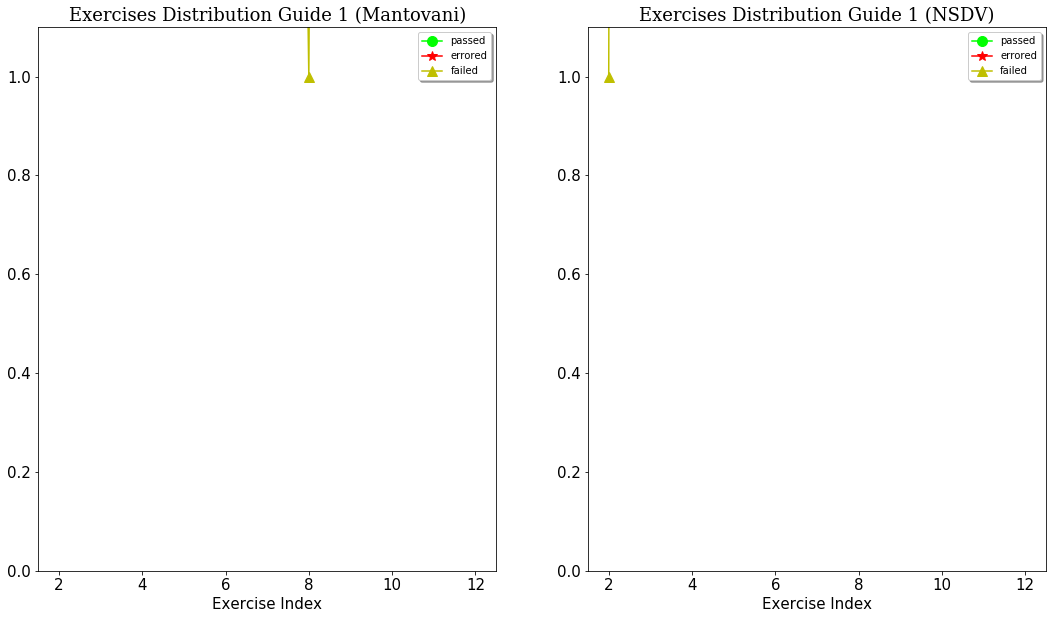

In [28]:
plot_realtion_submission_performance(guide_1_manto, guide_1_nds, 1)

## Guide 2
In section below, we compare performance between Mantonvani Students and Nuestra senhora del Valle in guide 2.

In [29]:
guide_2_manto = calculate_distribution_by_exercise(submission_manto_cleaned, guide_2.values(), 'submissions_status')
guide_2_nds = calculate_distribution_by_exercise(submission_nsdelvalle_cleaned, guide_2.values(), 'submissions_status')
print('Guide 2 Mantovani')
display(guide_2_manto)
print('\n\n Guide 2 Nuestra senhora del valle')
display(guide_2_nds)


Guide 2 Mantovani


,exercise,errored,failed,passed,passed_with_warnings,submission_amount
0,Calentando motores,5,1,31,NaN,37
1,Combinando comandos,8,30,26,NaN,64
2,Combinando comandos 2,2,21,24,NaN,47
3,Una escalerita,9,27,22,NaN,58
4,Portugal,6,22,20,NaN,48
5,"Y claro, no podía faltar Argentina",7,67,17,NaN,91
6,La Bandera de Paraguay,10,24,17,NaN,51
7,Limpiando el jardín,NaN,32,12,NaN,44
8,Reemplazar bolitas,2,8,9,NaN,19
9,La Bandera de Perú,10,78,9,NaN,97




 Guide 2 Nuestra senhora del valle


,exercise,errored,failed,passed,passed_with_warnings,submission_amount
0,Calentando motores,1,3,33,NaN,37
1,Combinando comandos,14,27,28,NaN,69
2,Combinando comandos 2,20,49,36,NaN,105
3,Una escalerita,10,48,25,NaN,83
4,Portugal,10,28,23,NaN,61
5,"Y claro, no podía faltar Argentina",25,57,13,NaN,95
6,La Bandera de Paraguay,3,22,8,NaN,33
7,Limpiando el jardín,NaN,10,7,NaN,17
8,Reemplazar bolitas,3,11,5,NaN,19
9,La Bandera de Perú,1,13,2,NaN,16


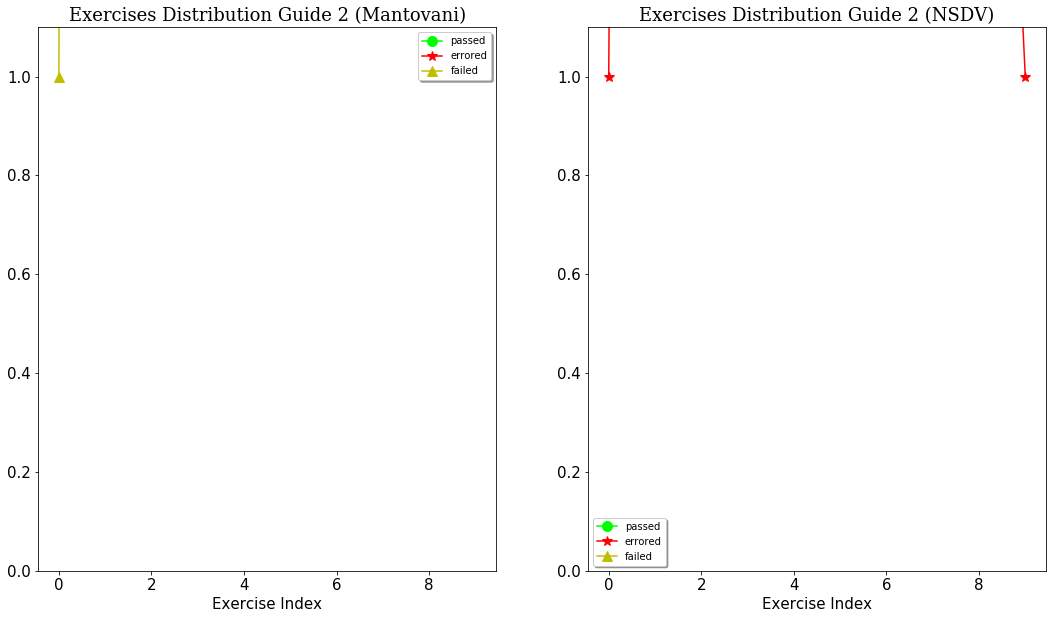

In [30]:
plot_realtion_submission_performance(guide_2_manto, guide_2_nds, 2)

## Guide 3
In section below, we compare performance between Mantonvani Students and Nuestra senhora del Valle in guide 3.


In [31]:
guide_3_manto = calculate_distribution_by_exercise(submission_manto_cleaned, guide_3.values(), 'submissions_status')
guide_3_nds = calculate_distribution_by_exercise(submission_nsdelvalle_cleaned, guide_3.values(), 'submissions_status')
print('Guide 3 Mantovani')
display(guide_3_manto)
print('\n\n Guide 3 Nuestra senhora del valle')
display(guide_3_nds)


Guide 3 Mantovani


,exercise,errored,failed,passed,passed_with_warnings,submission_amount
0,MoverOeste10,7,7,11,NaN,25
1,La computadora repite por nosotros,5,1,12,NaN,18
2,MoverOeste5 usando repeat,21,6,9,NaN,36
3,No todo es repetir,3,26,8,NaN,37
4,También vale después,2,4,8,2,16
5,Repitiendo varios comandos,2,2,7,1,12
6,¿Dónde está el error?,NaN,4,7,NaN,11
7,Diagonal con una bolita,7,8,6,NaN,21
8,"Diagonal ""pesada""",7,8,5,NaN,20
9,El caso borde,NaN,16,4,NaN,20




 Guide 3 Nuestra senhora del valle


,exercise,errored,failed,passed,passed_with_warnings,submission_amount
0,MoverOeste10,6,7,12,NaN,25
1,La computadora repite por nosotros,11,NaN,13,NaN,24
2,MoverOeste5 usando repeat,13,4,10,NaN,27
3,No todo es repetir,3,22,11,NaN,36
4,También vale después,5,8,10,NaN,23
5,Repitiendo varios comandos,7,6,9,8,30
6,¿Dónde está el error?,13,20,11,1,45
7,Diagonal con una bolita,4,10,8,1,23
8,"Diagonal ""pesada""",9,10,3,NaN,22
9,El caso borde,2,8,3,NaN,13


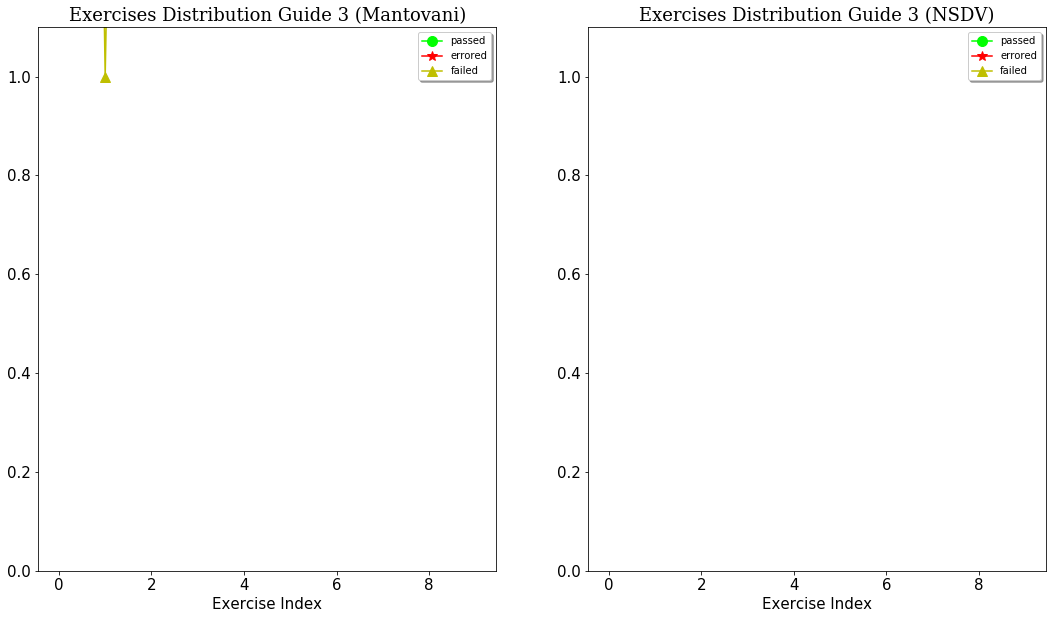

In [32]:
plot_realtion_submission_performance(guide_3_manto, guide_3_nds, 3)

## Guide 4
In section below, we compare performance between Mantonvani Students and Nuestra senhora del Valle in guide 4.


In [33]:
guide_4_manto = calculate_distribution_by_exercise(submission_manto_cleaned, guide_4.values(), 'submissions_status')
guide_4_nds = calculate_distribution_by_exercise(submission_nsdelvalle_cleaned, guide_4.values(), 'submissions_status')
print('Guide 4 Mantovani')
display(guide_4_manto)
print('\n\n Guide 4 Nuestra senhora del valle')
display(guide_4_nds)


Guide 4 Mantovani


,exercise,errored,failed,passed,passed_with_warnings,submission_amount
0,Sacar con miedo,NaN,NaN,2,NaN,2
1,"Sacar con miedo, segundo intento",NaN,NaN,NaN,NaN,0
2,Eliminando la bolita roja,NaN,NaN,2,NaN,2
3,Un ejemplo medio rebuscado,5,2,2,NaN,9
4,¿Y sólo sirve para ver si hay bolitas?,11,2,1,NaN,14
5,Un poquito de matemática,1,1,1,NaN,3
6,Cómo decirle que no...,1,2,1,NaN,4
7,Dos caminos distintos,NaN,NaN,1,NaN,1
8,Un tablero de luces,1,3,1,NaN,5




 Guide 4 Nuestra senhora del valle


,exercise,errored,failed,passed,passed_with_warnings,submission_amount
0,Sacar con miedo,NaN,NaN,3,NaN,3
1,"Sacar con miedo, segundo intento",NaN,NaN,NaN,NaN,0
2,Eliminando la bolita roja,11,15,3,NaN,29
3,Un ejemplo medio rebuscado,2,1,2,NaN,5
4,¿Y sólo sirve para ver si hay bolitas?,21,5,2,NaN,28
5,Un poquito de matemática,5,NaN,2,NaN,7
6,Cómo decirle que no...,13,10,1,NaN,24
7,Dos caminos distintos,NaN,NaN,1,NaN,1
8,Un tablero de luces,2,1,1,NaN,4


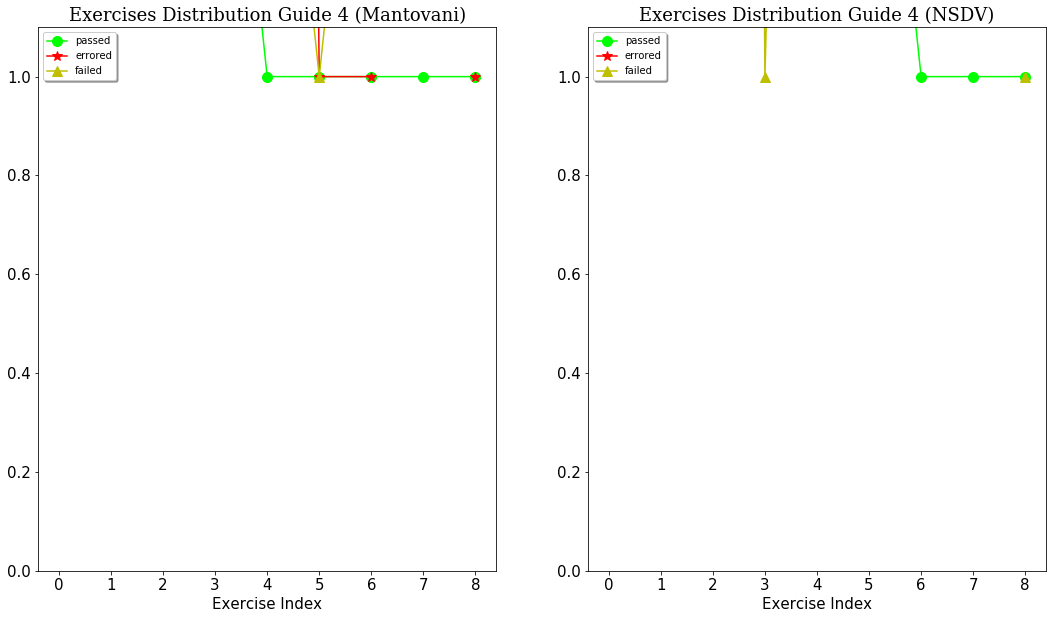

In [34]:
plot_realtion_submission_performance(guide_4_manto, guide_4_nds, 4)

## Distribution by all exercises 

In [35]:
res_to_print = result.fillna(value=0)
res_to_print = res_to_print[res_to_print['students_man'].astype(float) >= 7.0]
res_to_print = res_to_print[res_to_print['students_ns'].astype(float) >= 7.0]
res_to_print.shape

#print("{} \n {} \n{}\n".format(result['passed_man'][:10],result['failed_man'][:10],result['errored_man'][:10]))

(26, 14)

## Mantovani

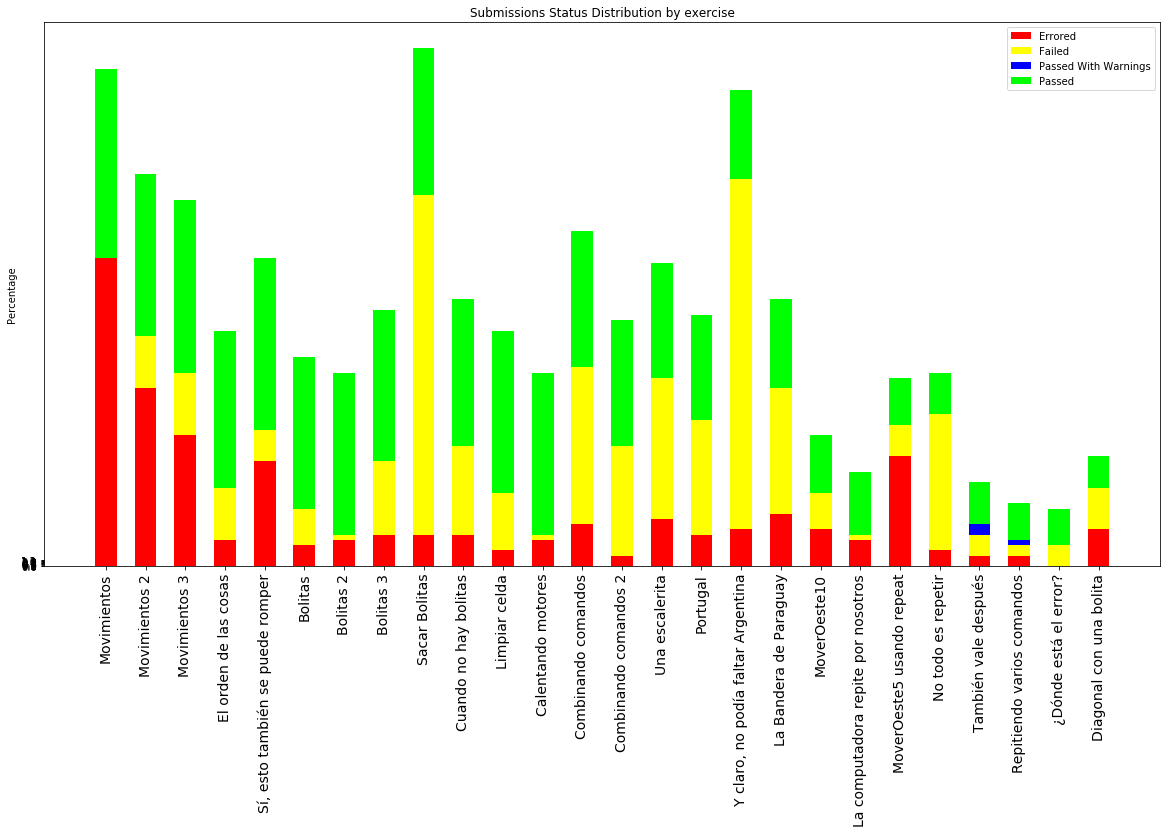

In [36]:
passed_man = res_to_print['passed_man']
failed_man = res_to_print['failed_man']
errored_man = res_to_print['errored_man']
passed_ww_man = res_to_print['passed_with_warnings_man']

ind = np.arange(len(errored_man))
width = 0.55
plt.figure(figsize=(20,10))
p1 = plt.bar(ind, errored_man, width, color='r')
p2 = plt.bar(ind, failed_man, width, bottom=errored_man, color='yellow')
p3 = plt.bar(ind, passed_ww_man, width, bottom=failed_man+errored_man, color='blue')
p4 = plt.bar(ind, passed_man, width, bottom=passed_ww_man+failed_man+errored_man, color='lime')

plt.ylabel('Percentage')
plt.title('Submissions Status Distribution by exercise')
plt.yticks(np.arange(0, 1.3, 0.1))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Errored', 'Failed', 'Passed With Warnings', 'Passed'))
plt.xticks(ind, res_to_print.index, rotation='vertical', fontsize=14)

plt.show()


## NSDV

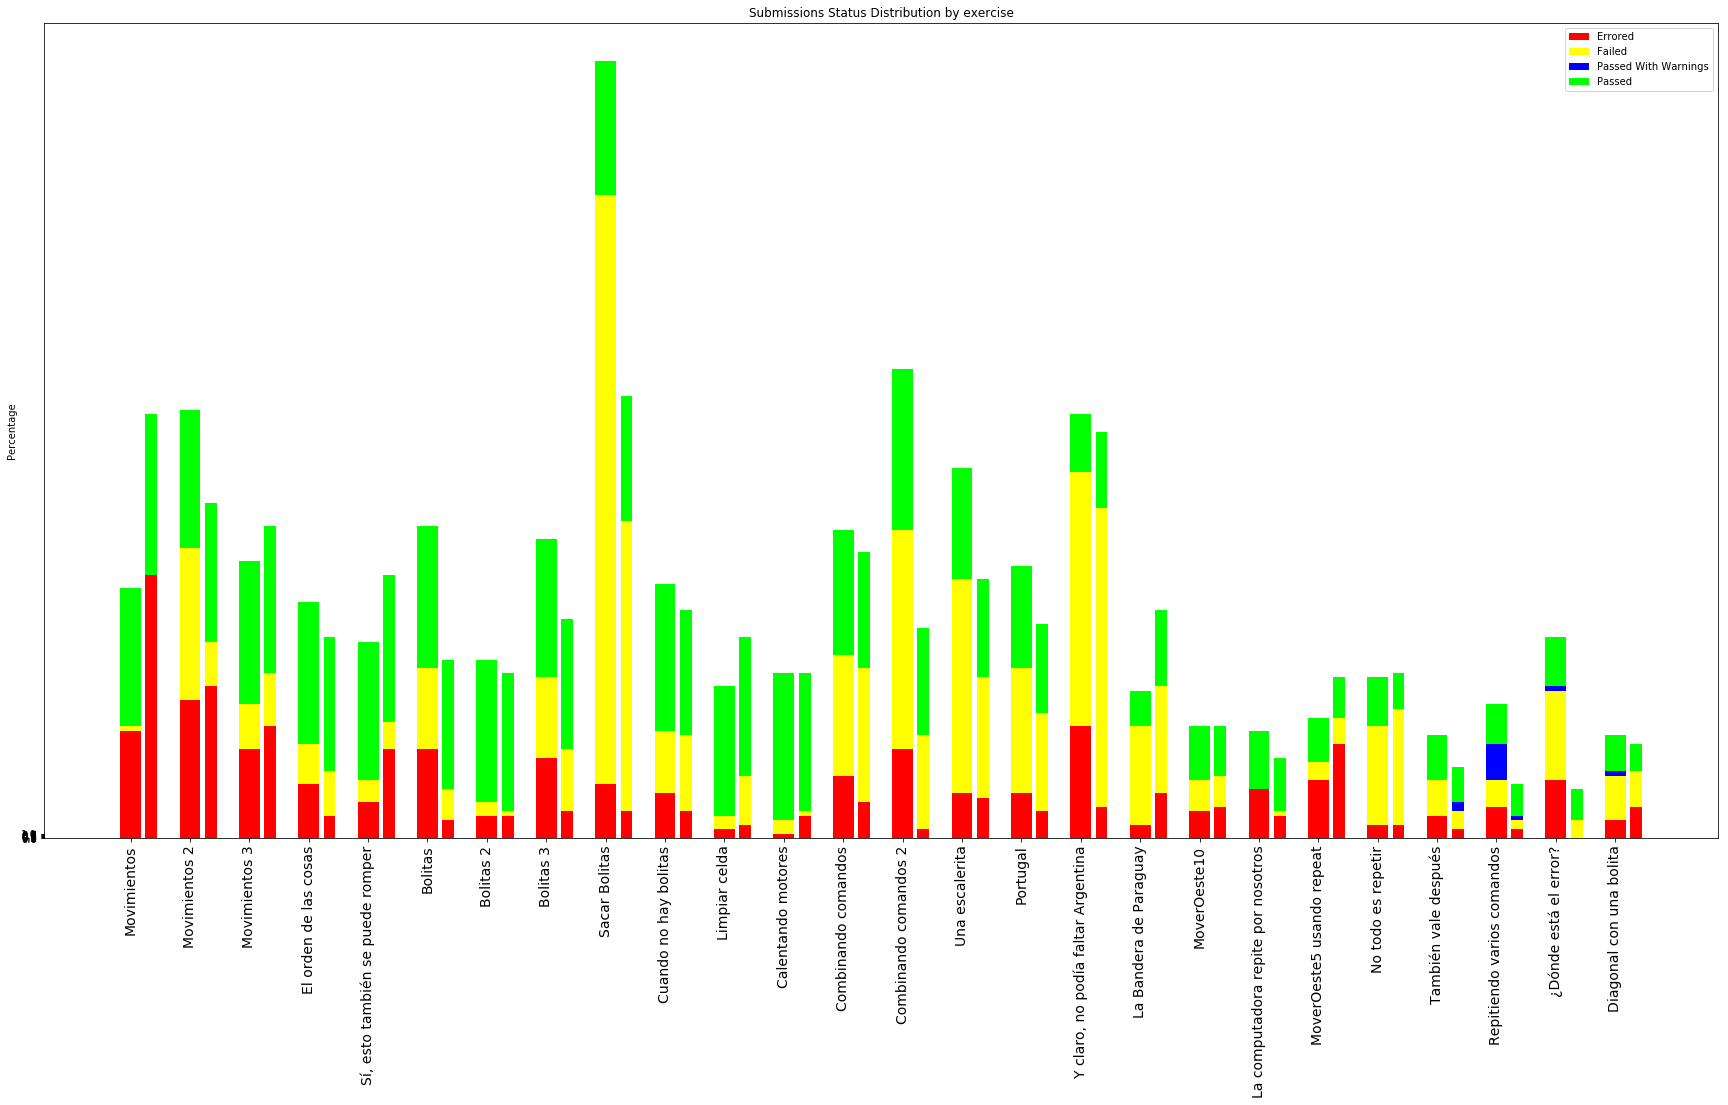

In [37]:
passed_ns = res_to_print['passed_ns']
failed_ns = res_to_print['failed_ns']
errored_ns = res_to_print['errored_ns']
passed_ww_ns = res_to_print['passed_with_warnings_ns']

ind = np.arange(len(errored_man))
width = 0.35
epsilon = 0.15
line_width = 1
plt.figure(figsize=(30,15))

p1 = plt.bar(ind, errored_ns, width, color='r', linewidth=line_width, label='Errored NSDV')
p2 = plt.bar(ind, failed_ns, width, bottom=errored_ns, color='yellow', linewidth=line_width, label='Failed NSDV')
p3 = plt.bar(ind, passed_ww_ns, width, bottom=failed_ns+errored_ns, color='blue', linewidth=line_width, label='Passed With Warning NSDV')
p4 = plt.bar(ind, passed_ns, width, bottom=passed_ww_ns+failed_ns+errored_ns, color='lime', linewidth=line_width, label='Passed NSDV')

p1b = plt.bar(ind+width, errored_man, width-epsilon, color='r', label='Errored Manto')
p2b = plt.bar(ind+width, failed_man, width-epsilon, bottom=errored_man, color='yellow', label='Failed Manto')
p3b = plt.bar(ind+width, passed_ww_man, width-epsilon, bottom=failed_man+errored_man, color='blue', label='Passed With Warning Manto')
p4b = plt.bar(ind+width, passed_man, width-epsilon, bottom=passed_ww_man+failed_man+errored_man, color='lime', label='Passed Manto')

plt.ylabel('Percentage')
plt.title('Submissions Status Distribution by exercise')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Errored', 'Failed', 'Passed With Warnings', 'Passed'))
plt.xticks(ind, res_to_print.index, rotation='vertical', fontsize=14)


plt.show()


# Mean exercise Submission 

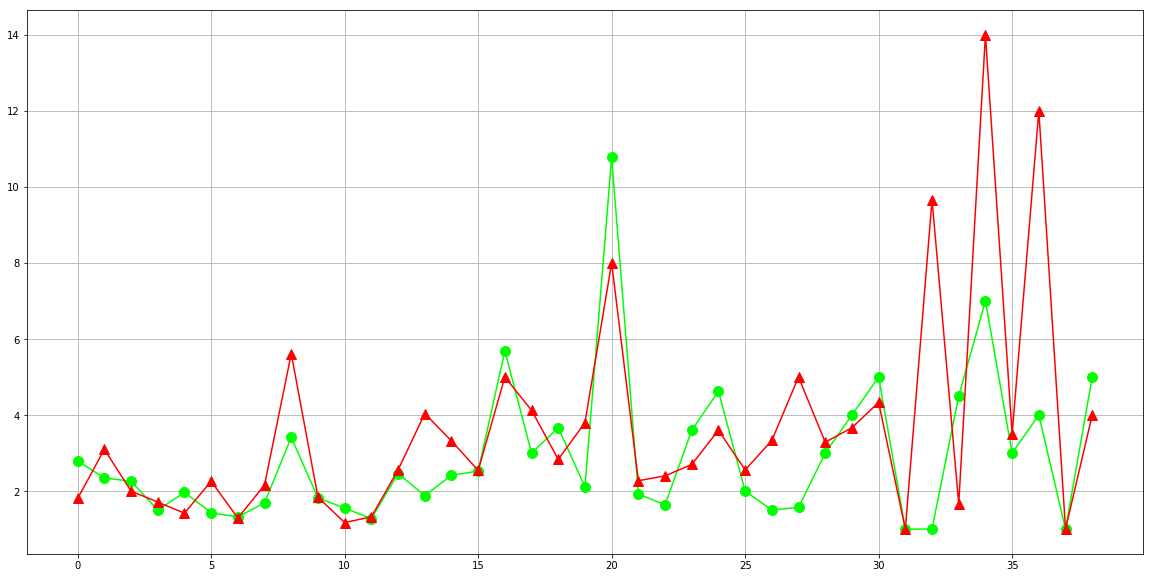

In [38]:

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot([i for i in range(39)],
             result['mean_sub_man'].astype(float), 'o-', color='lime', label='man',markersize=10)
ax.plot([i for i in range(39)],
             result['mean_sub_ns'].astype(float), '^-', color='red', label='nsdv',markersize=10)

ax.grid()


plt.show()


## Amount Student per exercise

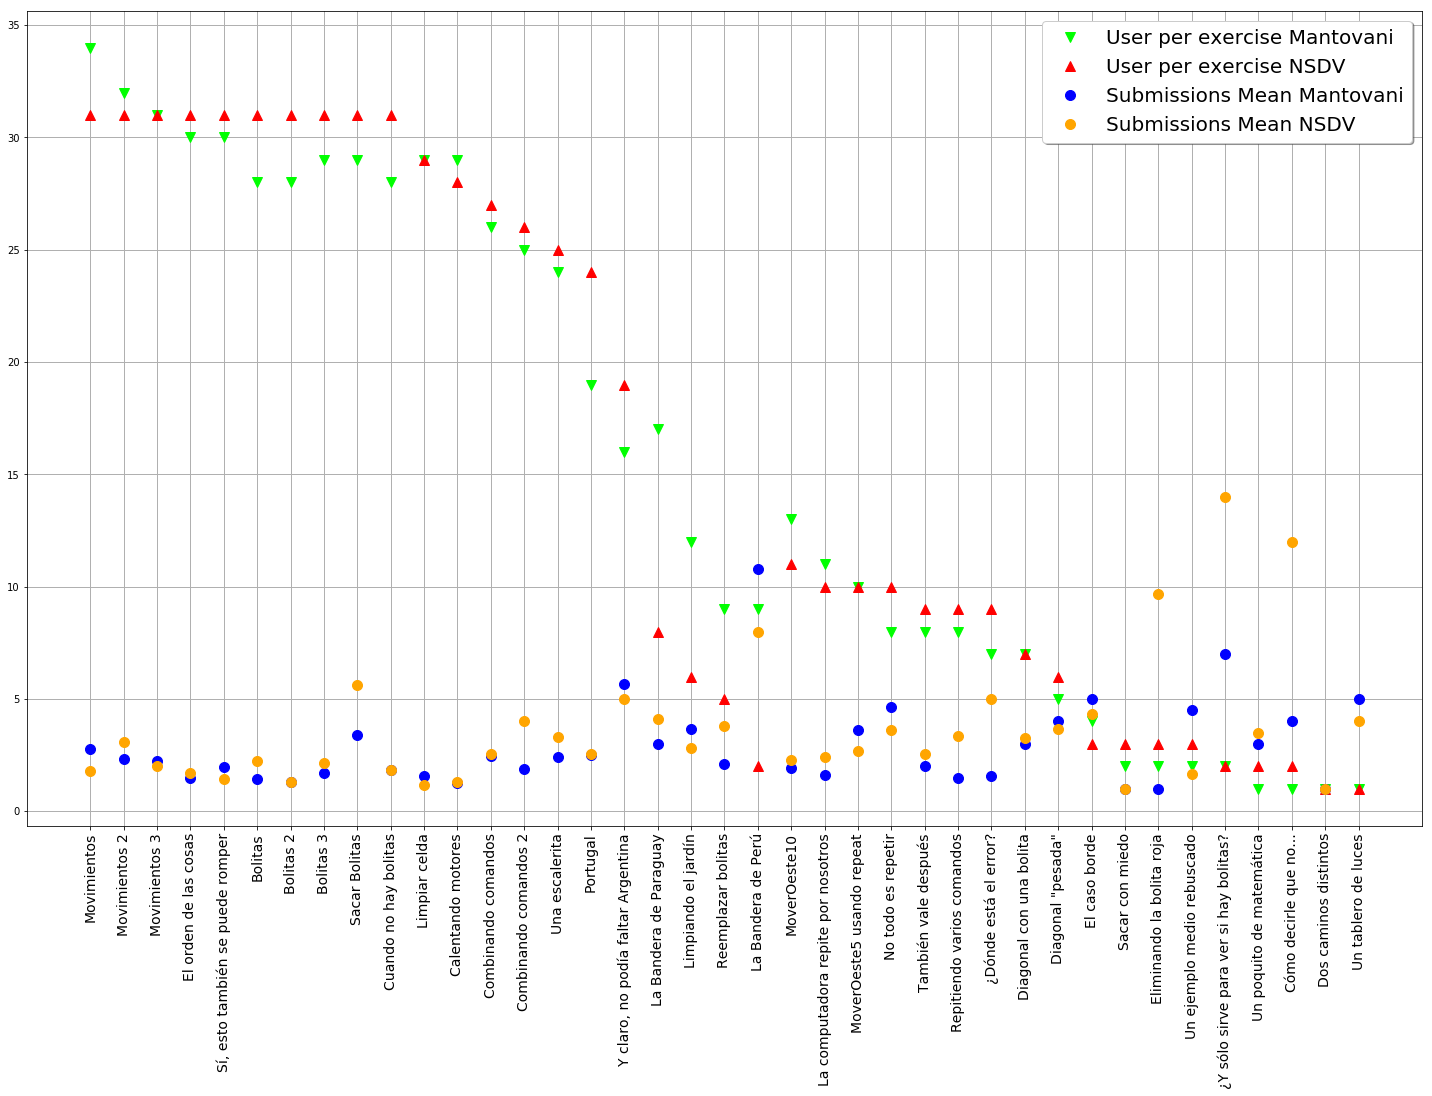

In [39]:

fig, ax = plt.subplots(figsize=(25, 15))

ax.plot([i for i in range(39)],
             result['students_man'].astype(float), 'v', color='lime', label='User per exercise Mantovani',markersize=10)

ax.plot([i for i in range(39)],
             result['students_ns'].astype(float), '^', color='red', label='User per exercise NSDV',markersize=10)

ax.plot([i for i in range(39)],
             result['mean_sub_man'].astype(float), 'o', color='blue', label='Submissions Mean Mantovani',markersize=10)

ax.plot([i for i in range(39)],
             result['mean_sub_ns'].astype(float), 'o', color='orange', label='Submissions Mean NSDV',markersize=10)


ax.grid(linestyle='-', linewidth=1)

legend = ax.legend(shadow=True, fontsize='large', fancybox=True,
        prop={'size': 20}, frameon=True, ncol=1, markerscale=1)
legend.get_frame().set_facecolor('white')

plt.xticks([i for i in range(39)], result.index, rotation='vertical', fontsize=14)

plt.show()



# Mean Submissions by Exercise 

In [40]:
print("Mantovani Students use more submissions than NSDV students in {} exercises".format(result[result['submission_amount_man'] > result['submission_amount_ns']].shape[0]))
print("NSDV Students use more submissions than Mantovani students in {} exercises".format(result[result['submission_amount_man'] < result['submission_amount_ns']].shape[0]))
print("NSDV Students and Mantovani students the same amount in {} exercises \n".format(result[result['submission_amount_man'] == result['submission_amount_ns']].shape[0]))


print('In Percentage')
print("Mantovani Students use more submissions than NSDV students in {} %".format(result[result['submission_amount_man'] > result['submission_amount_ns']].shape[0]/result.shape[0]))
print("NSDV Students use more submissions than Mantovani students in {} %".format(result[result['submission_amount_man'] < result['submission_amount_ns']].shape[0]/result.shape[0]))
print("NSDV Students and Mantovani students the same amount in {} %".format(result[result['submission_amount_man'] == result['submission_amount_ns']].shape[0]/result.shape[0]))

Mantovani Students use more submissions than NSDV students in 12 exercises
NSDV Students use more submissions than Mantovani students in 23 exercises
NSDV Students and Mantovani students the same amount in 4 exercises 

In Percentage
Mantovani Students use more submissions than NSDV students in 0.3076923076923077 %
NSDV Students use more submissions than Mantovani students in 0.5897435897435898 %
NSDV Students and Mantovani students the same amount in 0.10256410256410256 %


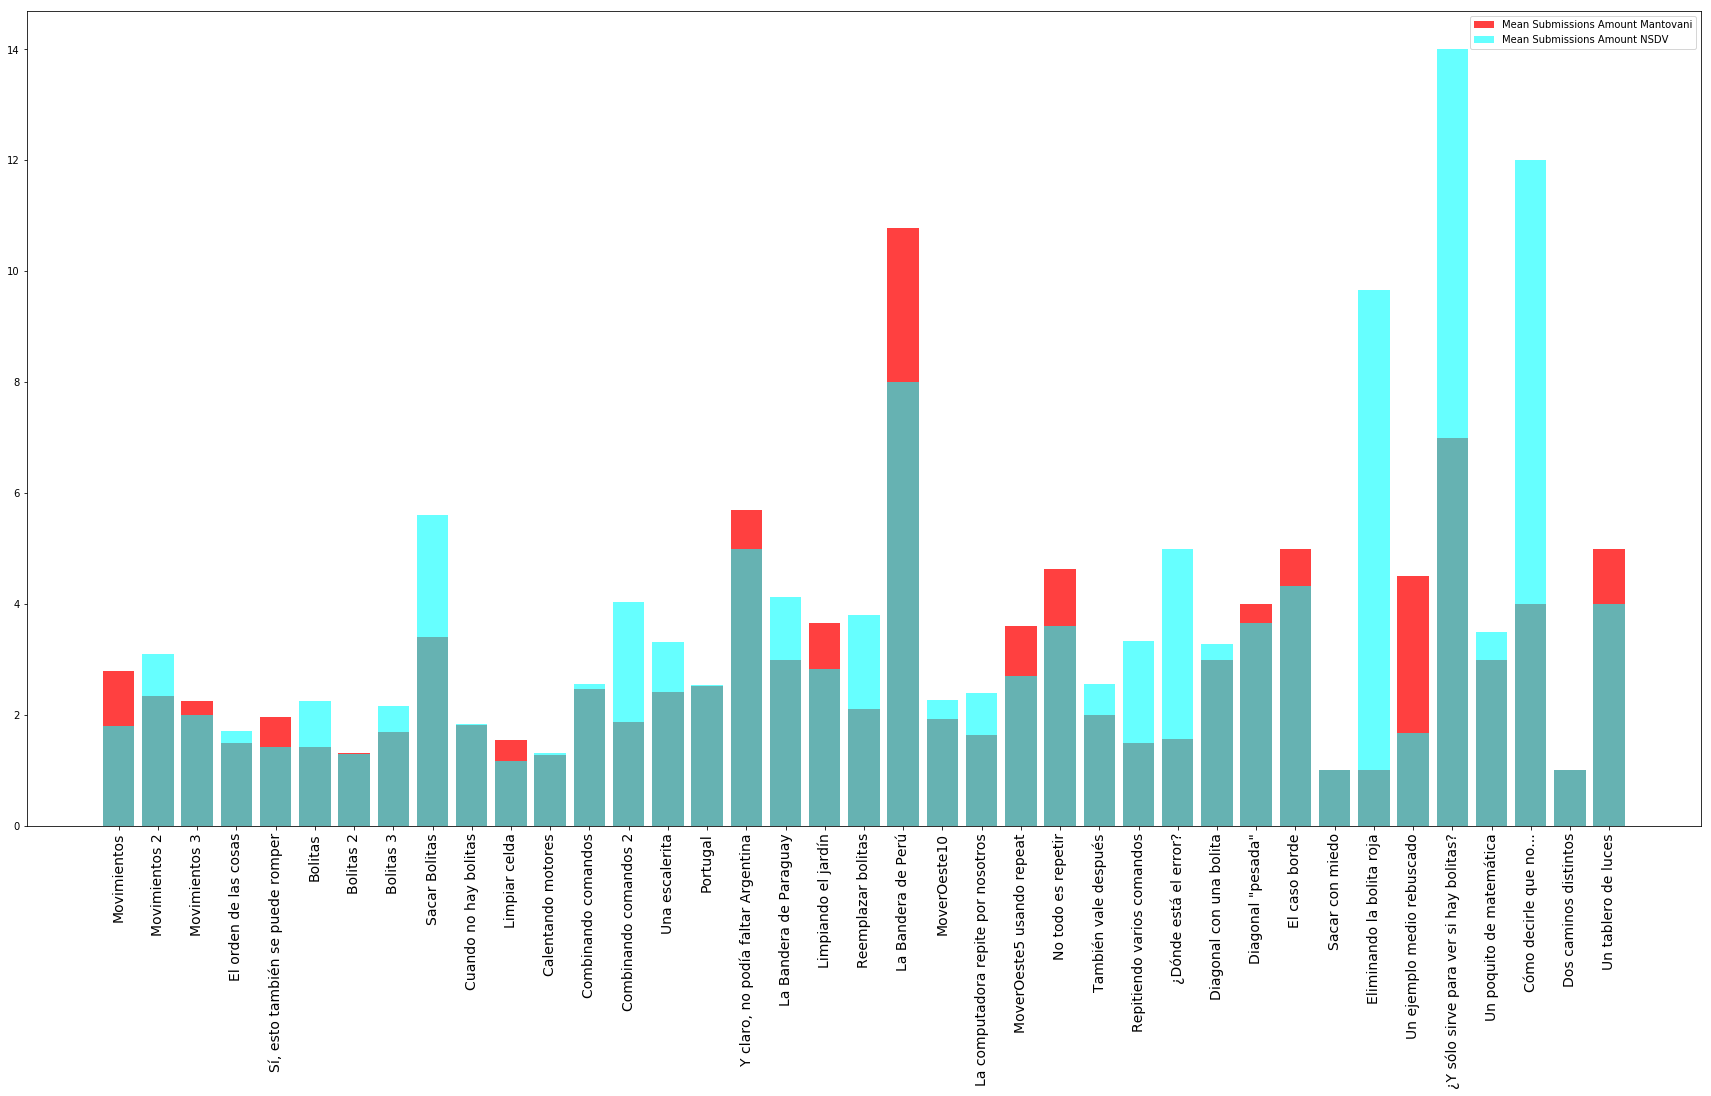

In [41]:
ind = np.arange(len(result['mean_sub_man']))
width = 0.35
epsilon = 0.15
line_width = 1
plt.figure(figsize=(30,15))

mean_man = plt.bar(ind, result['mean_sub_man'].astype(float), facecolor='red', alpha=0.75, label='Mean Submissions Amount Mantovani')
mean_nsdv = plt.bar(ind, result['mean_sub_ns'].astype(float), facecolor='cyan', alpha=0.6, label='Mean Submissions Amount NSDV')

plt.legend((mean_man[0], mean_nsdv[0]), ('Mean Submissions Amount Mantovani', 'Mean Submissions Amount NSDV'))

plt.xticks([i for i in range(39)], result.index, rotation='vertical', fontsize=14)

plt.show()


# Submissions Amount per exercise

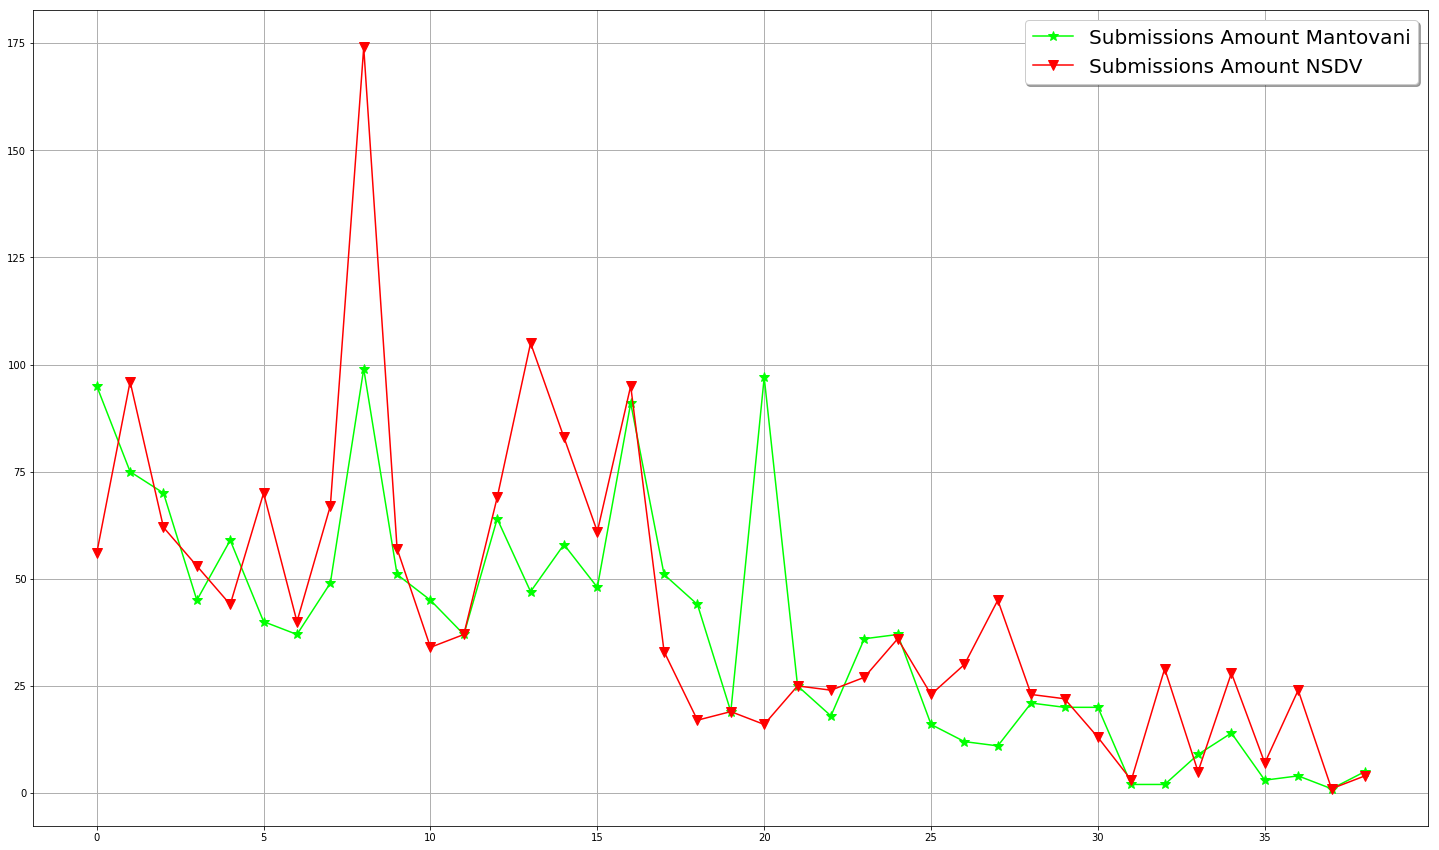

In [42]:
fig, ax = plt.subplots(figsize=(25, 15))

ax.plot([i for i in range(39)],
             result['submission_amount_man'].astype(float), '*-', color='lime', label='Submissions Amount Mantovani',markersize=10)
ax.plot([i for i in range(39)],
             result['submission_amount_ns'].astype(float), 'v-', color='red', label='Submissions Amount NSDV',markersize=10)

ax.grid(linestyle='-', linewidth=1)

legend = ax.legend(shadow=True, fontsize='large', fancybox=True,
        prop={'size': 20}, frameon=True, ncol=1, markerscale=1)
legend.get_frame().set_facecolor('white')

plt.show()

## Submissions by exercise and user


### Mantovani

In [43]:
sub_user_exer_man = submission_manto_cleaned.groupby(['student.email', 'exercise.name'])['submissions_submissions_count'].count().to_frame()
sub_user_exer_man.reset_index(inplace=True)
sub_user_exer_man = sub_user_exer_man.pivot(index='student.email', columns='exercise.name', values='submissions_submissions_count').fillna(value=0)
sub_user_exer_man.reindex(exercises_io, axis=1)

exercise.name,Movimientos,Movimientos 2,Movimientos 3,El orden de las cosas,"Sí, esto también se puede romper",Bolitas,Bolitas 2,Bolitas 3,Sacar Bolitas,Cuando no hay bolitas,...,"Diagonal ""pesada""",El caso borde,Sacar con miedo,Eliminando la bolita roja,Un ejemplo medio rebuscado,¿Y sólo sirve para ver si hay bolitas?,Un poquito de matemática,Cómo decirle que no...,Dos caminos distintos,Un tablero de luces
student.email,,,,,,,,,,,,,,,,,,,,,
ailin.honigman@mantovani.edu.ar,1.0,1.0,2.0,1.0,6.0,1.0,1.0,1.0,4.0,3.0,...,10.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aixa.bagur@mantovani.edu.ar,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
augusto.carnero@mantovani.edu.ar,5.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aylen.bossolino@mantovani.edu.ar,4.0,1.0,8.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
benjamin.sas@mantovani.edu.ar,1.0,2.0,2.0,1.0,1.0,2.0,5.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bianca.ferrari@mantovani.edu.ar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bonaldo.martin@mantovani.edu.ar,8.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
catalina.lavallen@mantovani.edu.ar,2.0,1.0,4.0,2.0,2.0,1.0,1.0,1.0,8.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eva.bertogna@mantovani.edu.ar,4.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### NSDV

In [44]:
sub_user_exer_nsdv = submission_nsdelvalle_cleaned.groupby(['student.email', 'exercise.name'])['submissions_submissions_count'].count().to_frame()
sub_user_exer_nsdv.reset_index(inplace=True)
sub_user_exer_nsdv = sub_user_exer_nsdv.pivot(index='student.email', columns='exercise.name', values='submissions_submissions_count').fillna(value=0)
sub_user_exer_nsdv = sub_user_exer_nsdv.reindex(exercises_io, axis=1)
sub_user_exer_nsdv

exercise.name,Movimientos,Movimientos 2,Movimientos 3,El orden de las cosas,"Sí, esto también se puede romper",Bolitas,Bolitas 2,Bolitas 3,Sacar Bolitas,Cuando no hay bolitas,...,"Diagonal ""pesada""",El caso borde,Sacar con miedo,Eliminando la bolita roja,Un ejemplo medio rebuscado,¿Y sólo sirve para ver si hay bolitas?,Un poquito de matemática,Cómo decirle que no...,Dos caminos distintos,Un tablero de luces
student.email,,,,,,,,,,,,,,,,,,,,,
camila.maccio@nsdelvalle.edu.ar,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
candela.zarate@nsdelvalle.edu.ar,2.0,5.0,1.0,2.0,2.0,1.0,1.0,1.0,13.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
catalina.molina@nsdelvalle.edu.ar,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
catalina.zito@nsdelvalle.edu.ar,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,7.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chiara.virgolini@nsdelvalle.edu.ar,2.0,5.0,4.0,2.0,1.0,8.0,1.0,8.0,6.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cristobal.velasco@nsdelvalle.edu.ar,1.0,7.0,3.0,1.0,1.0,1.0,2.0,1.0,11.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eliseo.stella@nsdelvalle.edu.ar,2.0,2.0,1.0,4.0,1.0,6.0,1.0,4.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
facundo.intili@nsdelvalle.edu.ar,1.0,14.0,1.0,1.0,2.0,9.0,3.0,1.0,4.0,1.0,...,1.0,8.0,1.0,4.0,1.0,17.0,4.0,9.0,0.0,0.0
facundo.pizarro@nsdelvalle.edu.ar,3.0,1.0,1.0,1.0,1.0,2.0,1.0,7.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Calculate last state for each student by exercise

## Manto

In [45]:
sub_user_stat_man = submission_manto_cleaned.groupby(['student.email', 'exercise.name'])['submissions_status'].last().to_frame()
sub_user_stat_man.reset_index(inplace=True)
sub_user_stat_man = sub_user_stat_man.pivot(index='student.email', columns='exercise.name', values='submissions_status')
sub_user_stat_man.reindex(exercises_io, axis=1)
sub_user_stat_man

exercise.name,Bolitas,Bolitas 2,Bolitas 3,Calentando motores,Combinando comandos,Combinando comandos 2,Cuando no hay bolitas,Cómo decirle que no...,"Diagonal ""pesada""",Diagonal con una bolita,...,Sacar con miedo,"Sí, esto también se puede romper",También vale después,Un ejemplo medio rebuscado,Un poquito de matemática,Un tablero de luces,Una escalerita,"Y claro, no podía faltar Argentina",¿Dónde está el error?,¿Y sólo sirve para ver si hay bolitas?
student.email,,,,,,,,,,,,,,,,,,,,,
ailin.honigman@mantovani.edu.ar,passed,passed,passed,passed,passed,passed,passed,NaN,passed,passed,...,NaN,passed,passed,NaN,NaN,NaN,passed,passed,passed,NaN
aixa.bagur@mantovani.edu.ar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
augusto.carnero@mantovani.edu.ar,passed,passed,passed,passed,passed,passed,passed,NaN,NaN,NaN,...,NaN,passed,NaN,NaN,NaN,NaN,passed,passed,NaN,NaN
aylen.bossolino@mantovani.edu.ar,passed,passed,passed,passed,passed,passed,passed,NaN,NaN,NaN,...,NaN,passed,NaN,NaN,NaN,NaN,passed,passed,NaN,NaN
benjamin.sas@mantovani.edu.ar,passed,passed,passed,passed,passed,passed,passed,NaN,NaN,errored,...,NaN,passed,passed,NaN,NaN,NaN,errored,NaN,passed,NaN
bianca.ferrari@mantovani.edu.ar,NaN,NaN,NaN,passed,passed,passed,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,passed,NaN,NaN,NaN
bonaldo.martin@mantovani.edu.ar,passed,passed,passed,passed,passed,passed,passed,NaN,NaN,NaN,...,NaN,passed,passed,NaN,NaN,NaN,passed,passed,NaN,NaN
catalina.lavallen@mantovani.edu.ar,passed,passed,passed,passed,passed,failed,passed,NaN,NaN,NaN,...,NaN,passed,NaN,NaN,NaN,NaN,failed,NaN,NaN,NaN
eva.bertogna@mantovani.edu.ar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
passed_exer_manto = pd.DataFrame(columns=['exercise', 'passed_amount_man'])
for exer in exercises_io:
  data = []
  data.append(exer)
  data.append(sub_user_stat_man[exer].value_counts()['passed'])
  passed_exer_manto.loc[len(passed_exer_manto)] = data



completed_man = pd.merge(data_complete[['exercise', 'students_man', 'submission_amount_man']], passed_exer_manto, on='exercise', how='outer')
completed_man['Completed Man'] = completed_man['passed_amount_man'] / completed_man['students_man']
completed_man

,exercise,students_man,submission_amount_man,passed_amount_man,Completed Man
0,Sacar con miedo,2.0,2,2,1
1,Eliminando la bolita roja,2.0,2,2,1
2,Un ejemplo medio rebuscado,2.0,9,2,1
3,¿Y sólo sirve para ver si hay bolitas?,2.0,14,1,0.5
4,Cómo decirle que no...,1.0,4,1,1
5,Un poquito de matemática,1.0,3,1,1
6,Dos caminos distintos,1.0,1,1,1
7,Un tablero de luces,1.0,5,1,1
8,Calentando motores,29.0,37,29,1
9,Combinando comandos,26.0,64,26,1


## NSDV

In [47]:
sub_user_stat_nsdv = submission_nsdelvalle_cleaned.groupby(['student.email', 'exercise.name'])['submissions_status'].last().to_frame()
sub_user_stat_nsdv.reset_index(inplace=True)
sub_user_stat_nsdv = sub_user_stat_nsdv.pivot(index='student.email', columns='exercise.name', values='submissions_status')
sub_user_stat_nsdv = sub_user_stat_nsdv.reindex(exercises_io, axis=1)
sub_user_stat_nsdv

exercise.name,Movimientos,Movimientos 2,Movimientos 3,El orden de las cosas,"Sí, esto también se puede romper",Bolitas,Bolitas 2,Bolitas 3,Sacar Bolitas,Cuando no hay bolitas,...,"Diagonal ""pesada""",El caso borde,Sacar con miedo,Eliminando la bolita roja,Un ejemplo medio rebuscado,¿Y sólo sirve para ver si hay bolitas?,Un poquito de matemática,Cómo decirle que no...,Dos caminos distintos,Un tablero de luces
student.email,,,,,,,,,,,,,,,,,,,,,
camila.maccio@nsdelvalle.edu.ar,passed,passed,passed,passed,passed,passed,passed,passed,passed,passed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
candela.zarate@nsdelvalle.edu.ar,passed,passed,passed,passed,passed,passed,passed,passed,passed,passed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
catalina.molina@nsdelvalle.edu.ar,passed,passed,passed,passed,passed,passed,passed,passed,passed,passed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
catalina.zito@nsdelvalle.edu.ar,passed,passed,passed,passed,passed,passed,passed,passed,passed,passed,...,failed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chiara.virgolini@nsdelvalle.edu.ar,passed,passed,passed,passed,passed,passed,passed,passed,passed,passed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cristobal.velasco@nsdelvalle.edu.ar,passed,passed,passed,passed,passed,passed,passed,passed,passed,passed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eliseo.stella@nsdelvalle.edu.ar,passed,passed,passed,passed,passed,passed,passed,passed,passed,passed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facundo.intili@nsdelvalle.edu.ar,passed,passed,passed,passed,passed,passed,passed,passed,passed,passed,...,passed,passed,passed,passed,passed,passed,passed,errored,NaN,NaN
facundo.pizarro@nsdelvalle.edu.ar,passed,passed,passed,passed,passed,passed,passed,passed,passed,passed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
passed_exer_nsdv = pd.DataFrame(columns=['exercise', 'passed_amount_ns'])
for exer in exercises_io:
  data = []
  data.append(exer)
  data.append(sub_user_stat_nsdv[exer].value_counts()['passed'])
  passed_exer_nsdv.loc[len(passed_exer_nsdv)] = data


completed_nsdv = pd.merge(data_complete[['exercise', 'students_ns', 'submission_amount_ns']], passed_exer_nsdv, on='exercise', how='outer')
completed_nsdv['Completed ns'] = completed_nsdv['passed_amount_ns'] / completed_nsdv['students_ns']
completed_nsdv

,exercise,students_ns,submission_amount_ns,passed_amount_ns,Completed ns
0,Sacar con miedo,3,3,3,1
1,Eliminando la bolita roja,3,29,3,1
2,Un ejemplo medio rebuscado,3,5,2,0.666667
3,¿Y sólo sirve para ver si hay bolitas?,2,28,2,1
4,Cómo decirle que no...,2,24,1,0.5
5,Un poquito de matemática,2,7,2,1
6,Dos caminos distintos,1,1,1,1
7,Un tablero de luces,1,4,1,1
8,Calentando motores,28,37,28,1
9,Combinando comandos,27,69,27,1


In [49]:
completed = pd.merge(completed_man, completed_nsdv, on='exercise', how='outer').fillna(value=0)
completed_mean = completed[['Completed Man', 'Completed ns']].mean()
completed


,exercise,students_man,submission_amount_man,passed_amount_man,Completed Man,students_ns,submission_amount_ns,passed_amount_ns,Completed ns
0,Sacar con miedo,2.0,2,2,1.000000,3,3,3,1.000000
1,Eliminando la bolita roja,2.0,2,2,1.000000,3,29,3,1.000000
2,Un ejemplo medio rebuscado,2.0,9,2,1.000000,3,5,2,0.666667
3,¿Y sólo sirve para ver si hay bolitas?,2.0,14,1,0.500000,2,28,2,1.000000
4,Cómo decirle que no...,1.0,4,1,1.000000,2,24,1,0.500000
5,Un poquito de matemática,1.0,3,1,1.000000,2,7,2,1.000000
6,Dos caminos distintos,1.0,1,1,1.000000,1,1,1,1.000000
7,Un tablero de luces,1.0,5,1,1.000000,1,4,1,1.000000
8,Calentando motores,29.0,37,29,1.000000,28,37,28,1.000000
9,Combinando comandos,26.0,64,26,1.000000,27,69,27,1.000000


In [50]:
cols_order = ['Movimientos_amount', 'Movimientos_status',
'Movimientos 2_amount','Movimientos 2_status',
'Movimientos 3_amount','Movimientos 3_status',
'El orden de las cosas_amount', 'El orden de las cosas_status',
'Sí, esto también se puede romper_amount','Sí, esto también se puede romper_status',
'Bolitas_amount', 'Bolitas_status',
'Bolitas 2_amount', 'Bolitas 2_status',
'Bolitas 3_amount','Bolitas 3_status',
'Sacar Bolitas_amount', 'Sacar Bolitas_status',
'Cuando no hay bolitas_amount', 'Cuando no hay bolitas_status',
'Limpiar celda_amount', 'Limpiar celda_status',
'Calentando motores_amount', 'Calentando motores_status',
'Combinando comandos_amount', 'Combinando comandos_status',
'Combinando comandos 2_amount', 'Combinando comandos 2_status',
'Una escalerita_amount', 'Una escalerita_status',
'Portugal_amount', 'Portugal_status',
'Y claro, no podía faltar Argentina_amount', 'Y claro, no podía faltar Argentina_status',
'La Bandera de Paraguay_amount','La Bandera de Paraguay_status',
'Limpiando el jardín_amount', 'Limpiando el jardín_status',
'Reemplazar bolitas_amount', 'Reemplazar bolitas_status',
'La Bandera de Perú_amount', 'La Bandera de Perú_status',
'MoverOeste10_amount', 'MoverOeste10_status',
'La computadora repite por nosotros_amount', 'La computadora repite por nosotros_status',
'MoverOeste5 usando repeat_amount', 'MoverOeste5 usando repeat_status',
'No todo es repetir_amount', 'No todo es repetir_status',
'También vale después_amount', 'También vale después_status',
'Repitiendo varios comandos_amount', 'Repitiendo varios comandos_status',
'¿Dónde está el error?_amount', '¿Dónde está el error?_status',
'Diagonal con una bolita_amount', 'Diagonal con una bolita_status',
'Diagonal "pesada"_amount', 'Diagonal "pesada"_status',
'El caso borde_amount','El caso borde_status',
'Sacar con miedo_amount','Sacar con miedo_status',
'Eliminando la bolita roja_amount','Eliminando la bolita roja_status',
'Un ejemplo medio rebuscado_amount', 'Un ejemplo medio rebuscado_status',
'¿Y sólo sirve para ver si hay bolitas?_amount','¿Y sólo sirve para ver si hay bolitas?_status',
'Un poquito de matemática_amount','Un poquito de matemática_status',
'Cómo decirle que no..._amount','Cómo decirle que no..._status',
'Dos caminos distintos_amount', 'Dos caminos distintos_status',
'Un tablero de luces_amount', 'Un tablero de luces_status']

# Join Last State and Submissions amount by Student and Exercise

## Manto

In [51]:
manto_joined = sub_user_exer_man.join(sub_user_stat_man, lsuffix='_amount', rsuffix='_status')
manto_joined.reindex(cols_order, axis=1)

exercise.name,Movimientos_amount,Movimientos_status,Movimientos 2_amount,Movimientos 2_status,Movimientos 3_amount,Movimientos 3_status,El orden de las cosas_amount,El orden de las cosas_status,"Sí, esto también se puede romper_amount","Sí, esto también se puede romper_status",...,¿Y sólo sirve para ver si hay bolitas?_amount,¿Y sólo sirve para ver si hay bolitas?_status,Un poquito de matemática_amount,Un poquito de matemática_status,Cómo decirle que no..._amount,Cómo decirle que no..._status,Dos caminos distintos_amount,Dos caminos distintos_status,Un tablero de luces_amount,Un tablero de luces_status
student.email,,,,,,,,,,,,,,,,,,,,,
ailin.honigman@mantovani.edu.ar,1.0,passed,1.0,passed,2.0,passed,1.0,passed,6.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
aixa.bagur@mantovani.edu.ar,1.0,passed,7.0,errored,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
augusto.carnero@mantovani.edu.ar,5.0,passed,2.0,passed,1.0,passed,1.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
aylen.bossolino@mantovani.edu.ar,4.0,passed,1.0,passed,8.0,passed,1.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
benjamin.sas@mantovani.edu.ar,1.0,passed,2.0,passed,2.0,passed,1.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
bianca.ferrari@mantovani.edu.ar,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
bonaldo.martin@mantovani.edu.ar,8.0,passed,2.0,passed,1.0,passed,1.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
catalina.lavallen@mantovani.edu.ar,2.0,passed,1.0,passed,4.0,passed,2.0,passed,2.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
eva.bertogna@mantovani.edu.ar,4.0,passed,1.0,passed,2.0,passed,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


## NSDV

In [52]:
nsdv_joined = sub_user_exer_nsdv.join(sub_user_stat_nsdv, lsuffix='_amount', rsuffix='_status')
nsdv_joined.reindex(cols_order, axis=1)

exercise.name,Movimientos_amount,Movimientos_status,Movimientos 2_amount,Movimientos 2_status,Movimientos 3_amount,Movimientos 3_status,El orden de las cosas_amount,El orden de las cosas_status,"Sí, esto también se puede romper_amount","Sí, esto también se puede romper_status",...,¿Y sólo sirve para ver si hay bolitas?_amount,¿Y sólo sirve para ver si hay bolitas?_status,Un poquito de matemática_amount,Un poquito de matemática_status,Cómo decirle que no..._amount,Cómo decirle que no..._status,Dos caminos distintos_amount,Dos caminos distintos_status,Un tablero de luces_amount,Un tablero de luces_status
student.email,,,,,,,,,,,,,,,,,,,,,
camila.maccio@nsdelvalle.edu.ar,1.0,passed,2.0,passed,2.0,passed,1.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
candela.zarate@nsdelvalle.edu.ar,2.0,passed,5.0,passed,1.0,passed,2.0,passed,2.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
catalina.molina@nsdelvalle.edu.ar,1.0,passed,1.0,passed,2.0,passed,2.0,passed,2.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
catalina.zito@nsdelvalle.edu.ar,1.0,passed,1.0,passed,1.0,passed,2.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
chiara.virgolini@nsdelvalle.edu.ar,2.0,passed,5.0,passed,4.0,passed,2.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
cristobal.velasco@nsdelvalle.edu.ar,1.0,passed,7.0,passed,3.0,passed,1.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
eliseo.stella@nsdelvalle.edu.ar,2.0,passed,2.0,passed,1.0,passed,4.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
facundo.intili@nsdelvalle.edu.ar,1.0,passed,14.0,passed,1.0,passed,1.0,passed,2.0,passed,...,17.0,passed,4.0,passed,9.0,errored,0.0,NaN,0.0,NaN
facundo.pizarro@nsdelvalle.edu.ar,3.0,passed,1.0,passed,1.0,passed,1.0,passed,1.0,passed,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


# Stadistic Analysis

In [53]:
exer_man = calculate_distribution_by_exercise(submission_manto_cleaned, exercises_manto, 'submissions_status', mean=False).fillna(value=0)
exer_nsdv = calculate_distribution_by_exercise(submission_nsdelvalle_cleaned, exercises_manto, 'submissions_status', mean=False).fillna(value=0)

sa_result = pd.merge(exer_man, exer_nsdv, on='exercise', suffixes =('_ns', '_man'), how='outer')

sa_result = pd.merge(sa_result, students_manto, on='exercise', how='outer')
sa_result = pd.merge(sa_result, students_nsdv, on='exercise', how='outer')

sa_result = sa_result.reindex_axis(
    ['exercise', 'errored_man', 'errored_ns', 'failed_man', 'failed_ns', 'passed_man', 'passed_ns', 'passed_with_warnings_man', 'passed_with_warnings_ns', 'submission_amount_man', 'students_man', 'submission_amount_ns', 'students_ns'], axis=1)


sa_result = sa_result.set_index('exercise')
sa_result = sa_result.reindex(exercises_io)
sa_result


,errored_man,errored_ns,failed_man,failed_ns,passed_man,passed_ns,passed_with_warnings_man,passed_with_warnings_ns,submission_amount_man,students_man,submission_amount_ns,students_ns
exercise,,,,,,,,,,,,
Movimientos,24.0,59.0,1.0,0.0,31.0,36.0,0.0,0.0,56.0,34.0,95.0,31
Movimientos 2,31.0,34.0,34.0,10.0,31.0,31.0,0.0,0.0,96.0,32.0,75.0,31
Movimientos 3,20.0,25.0,10.0,12.0,32.0,33.0,0.0,0.0,62.0,31.0,70.0,31
El orden de las cosas,12.0,5.0,9.0,10.0,32.0,30.0,0.0,0.0,53.0,30.0,45.0,31
"Sí, esto también se puede romper",8.0,20.0,5.0,6.0,31.0,33.0,0.0,0.0,44.0,30.0,59.0,31
Bolitas,20.0,4.0,18.0,7.0,32.0,29.0,0.0,0.0,70.0,28.0,40.0,31
Bolitas 2,5.0,5.0,3.0,1.0,32.0,31.0,0.0,0.0,40.0,28.0,37.0,31
Bolitas 3,18.0,6.0,18.0,14.0,31.0,29.0,0.0,0.0,67.0,29.0,49.0,31
Sacar Bolitas,12.0,6.0,132.0,65.0,30.0,28.0,0.0,0.0,174.0,29.0,99.0,31


In [54]:
#from google.colab import files
#sa_result.to_csv('df.csv')
#files.download("df.csv")
#from scipy import stats


# Analyze 6th Grade Experience

In [55]:
submissions_6_df = pd.DataFrame()

files_6 = ['2017-6to-grado.json']
for file in files_6:
  json_file = open('./data/'+str(file), encoding='utf8')
  json_data = json.load(json_file)
  submissions_6 = pd.io.json.json_normalize(
      json_data, 'submissions', [['guide','slug'], ['student','email'],['guide','name'], ['exercise','name'],['exercise','eid'],['guide','language','name']], record_prefix='submissions_', errors='ignore')
  submissions_6_df = submissions_6_df.append(submissions_6)

  
submissions_6_df.shape

FileNotFoundError: [Errno 2] No such file or directory: './data/2017-6to-grado.json'

## Remove Exercises without code

In [ ]:
submissions_expanded_6 = submissions_6_df[submissions_6_df['guide.language.name'].str.contains('gobstone')]
submissions_expanded_6 = submissions_expanded_6.drop(
    submissions_expanded_6[(submissions_expanded_6['exercise.name'] == 'Escribiendo procedimientos') |
                         (submissions_expanded_6['exercise.name'] == 'Un programa un poco largo') |
                         (submissions_expanded_6['exercise.name'] == 'El Tablero') |
                         (submissions_expanded_6['exercise.name'] == 'Sacar con miedo, segundo intento') |
                         (submissions_expanded_6['exercise.name'] == 'El Cabezal') |
                         (submissions_expanded_6['exercise.name'] == 'Las cosas por su nombre') 
                        ].index)
submissions_expanded_6.shape

## Remove Test User

In [ ]:
submissions_expanded_6 = submissions_expanded_6[~(submissions_expanded_6['student.email'] == 'prueba@mantovani.edu.ar')]
submissions_expanded_6.shape

## Clean Submissions

In [ ]:
submissions_6_cleaned = clean_submissions(submissions_expanded_6, 'submissions_status')
submissions_6_cleaned = submissions_6_cleaned[~(submissions_6_cleaned['exercise.name'] == 'Enseñándole tareas a la computadora')]
submissions_6_cleaned = submissions_6_cleaned[~(submissions_6_cleaned['exercise.name'] == 'Una definición, "infinitos" usos')]
submissions_6_cleaned = submissions_6_cleaned[~(submissions_6_cleaned['exercise.name'] == 'Pensando en subtareas')]
calculate_distribution(submissions_6_cleaned, 'submissions_status', 'Mantovani 6th Submissions')

In [ ]:
print('Exercises not solved by 5th Grade \n' )
print(set(submissions_6_cleaned['exercise.name'].unique()).difference(set(exer)))

## Amount Students

In [ ]:
print("Amount of students {} ".format(submissions_6_cleaned['student.email'].nunique()))
print("Amount of Submissions {} ".format(submissions_6_cleaned.shape[0]))

In [ ]:
submissions_6_cleaned['submissions_submissions_count'] = submissions_6_cleaned['submissions_submissions_count'] +1

In [ ]:
students_6th = submissions_6_cleaned.groupby(['exercise.name'])['student.email'].nunique().reset_index(name='students_6th')
students_6th.rename(columns={'exercise.name': 'exercise'}, inplace=True)
students_6th

## Distribution by Exercise

In [ ]:
exercises_6th = submissions_6_cleaned['exercise.name'].unique()
distribution_6th = calculate_distribution_by_exercise(submissions_6_cleaned, exercises_6th, 'submissions_status')
distribution_6th

In [ ]:
result_6th = pd.merge(distribution_6th, students_6th, on='exercise', how='outer')
result_6th['submissions_mean'] = result_6th['submission_amount'] / result_6th['students_6th']
result_6th

## Submissions by user and exercise

In [ ]:
sub_user_exer_6th = submissions_6_cleaned.groupby(['student.email', 'exercise.name'])['submissions_submissions_count'].count().to_frame()
sub_user_exer_6th.reset_index(inplace=True)
sub_user_exer_6th = sub_user_exer_6th.pivot(index='student.email', columns='exercise.name', values='submissions_submissions_count').fillna(value=0)
sub_user_exer_6th = sub_user_exer_6th.reindex(exercises_io, axis=1)
sub_user_exer_6th

In [ ]:
sub_user_stat_6th = submissions_6_cleaned.groupby(['student.email', 'exercise.name'])['submissions_status'].last().to_frame()
sub_user_stat_6th.reset_index(inplace=True)
sub_user_stat_6th = sub_user_stat_6th.pivot(index='student.email', columns='exercise.name', values='submissions_status')
sub_user_stat_6th = sub_user_stat_6th.reindex(exercises_io, axis=1)
sub_user_stat_6th

In [ ]:
joined_6th = sub_user_exer_6th.join(sub_user_stat_6th, lsuffix='_amount', rsuffix='_status')
joined_6th.reindex(cols_order, axis=1)

In [ ]:
result_6th_to_print = result_6th[result_6th['students_6th'].astype(float) >= 7.0].fillna(value=0)
result_6th_to_print = result_6th_to_print.set_index('exercise')
result_6th_to_print = result_6th_to_print.reindex(exercises_io)
result_6th_to_print

In [ ]:
passed_man = result_6th_to_print['passed']
failed_man = result_6th_to_print['failed']
errored_man = result_6th_to_print['errored']
passed_ww_man = result_6th_to_print['passed_with_warnings']

ind = np.arange(len(errored_man))
width = 0.55
plt.figure(figsize=(20,10))
p1 = plt.bar(ind, errored_man, width, color='r')
p2 = plt.bar(ind, failed_man, width, bottom=errored_man, color='yellow')
p3 = plt.bar(ind, passed_ww_man, width, bottom=failed_man+errored_man, color='blue')
p4 = plt.bar(ind, passed_man, width, bottom=passed_ww_man+failed_man+errored_man, color='lime')

plt.ylabel('Percentage')
plt.title('Submissions Status Distribution by exercise')
plt.yticks(np.arange(0, 1.3, 0.1))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Errored', 'Failed', 'Passed With Warnings', 'Passed'))
plt.xticks(ind, result_6th_to_print.index, rotation='vertical', fontsize=14)


plt.show()


# New Metrics suggested by Luciana

In [ ]:
amount_sub_df = data_complete[['exercise', 'students_man', 'submission_amount_man', 'mean_sub_man', 'students_ns', 'submission_amount_ns', 'mean_sub_ns']]
amount_sub_df = amount_sub_df.set_index('exercise')
amount_sub_df = amount_sub_df.reindex(exercises_io)
amount_sub_df

In [ ]:
sub_manto_cleaned = submission_manto_cleaned
sub_nsdv_cleaned = submission_nsdelvalle_cleaned
sub_manto_cleaned['submissions_created_at'] = pd.to_datetime(sub_manto_cleaned['submissions_created_at'])
sub_nsdv_cleaned['submissions_created_at'] = pd.to_datetime(sub_nsdv_cleaned['submissions_created_at'])

print(sub_nsdv_cleaned['submissions_created_at'].max() - sub_nsdv_cleaned['submissions_created_at'].min())
print(sub_manto_cleaned['submissions_created_at'].max() - sub_manto_cleaned['submissions_created_at'].min())

In [ ]:
time_between_submmissions = sub_manto_cleaned['submissions_created_at'].diff()
time_between_submmissions = time_between_submmissions[time_between_submmissions >= pd.Timedelta(days=0)].dropna()
time_between_submmissions = time_between_submmissions[time_between_submmissions < pd.Timedelta(minutes=30)].dropna()


time_between_submmissions_nsdv = sub_nsdv_cleaned['submissions_created_at'].diff()
time_between_submmissions_nsdv = time_between_submmissions_nsdv[time_between_submmissions_nsdv >= pd.Timedelta(days=0)].dropna()
time_between_submmissions_nsdv = time_between_submmissions_nsdv[time_between_submmissions_nsdv < pd.Timedelta(minutes=30)].dropna()


%matplotlib inline
plt.figure(figsize=(20,10))
plt.axis([-2, 250, 0, 250])
plt.hist(time_between_submmissions.astype('timedelta64[s]').sort_values(), bins=400, label='freq Mantovani')
plt.hist(time_between_submmissions_nsdv.astype('timedelta64[s]').sort_values(), bins=400, alpha=.3, color='r', label='freq NSDV')
plt.legend()
plt.xlabel('Interval between submissions (s)')
plt.ylabel('Amount submissions')


In [ ]:
sub_manto_cleaned.head(10)

In [ ]:
def calculate_completion(df):
  passed = 0
  attempt = 0
  completion_df = pd.DataFrame(columns=['student', 'attempt', 'passed'])
  emails = df['student.email'].unique()
  for email in emails:
    passed = 0
    attempt = 0
    exercises_by_student = df[df['student.email'] == email]['exercise.name'].unique()
    for exercise in exercises_by_student:
      exer_df = df[(df['student.email'] == email) & (df['exercise.name'] == exercise)]
      if exer_df[exer_df['submissions_status'] == 'passed'].shape[0] > 0:
        passed += 1
        attempt += 1
      else:
        attempt += 1
    data = {'student': email, 'attempt': attempt, 'passed': passed}
    completion_df.loc[len(completion_df)+1] = data

  completion_df['completion'] = completion_df['passed'] / completion_df['attempt']
  return completion_df, completion_df['completion'].mean()

In [56]:
manto_completion, mean_completion_manto = calculate_completion(submission_manto_cleaned)
nsdv_completion, mean_completion_nsdv = calculate_completion(submission_nsdelvalle_cleaned)

NameError: name 'calculate_completion' is not defined

In [57]:
manto_completion

NameError: name 'manto_completion' is not defined

In [58]:
nsdv_completion

NameError: name 'nsdv_completion' is not defined

In [59]:
def calculate_pww_proportion(df):
  completion_df = pd.DataFrame(columns=['student', 'passed', 'passed_with_warning'])
  emails = df['student.email'].unique()
  for email in emails:
    passed = 0
    passed_with_warnings = 0
    exercises_by_student = df[df['student.email'] == email]['exercise.name'].unique()
    for exercise in exercises_by_student:
      exer_df = df[(df['student.email'] == email) & (df['exercise.name'] == exercise)]
      if exer_df[exer_df['submissions_status'] == 'passed'].shape[0] > 0:
        passed += 1
        if exer_df[exer_df['submissions_status'] == 'passed_with_warnings'].shape[0] > 0:
          passed_with_warnings += 1
    data = {'student': email, 'passed': passed, 'passed_with_warning': passed_with_warnings}
    completion_df.loc[len(completion_df)+1] = data

  completion_df['proportion_pww'] = completion_df['passed_with_warning'] / completion_df['passed']
  return completion_df, completion_df['proportion_pww'].mean()

In [60]:
pww_manto, mean_pww_manto = calculate_pww_proportion(submission_manto_cleaned)

In [61]:
pww_manto

,student,passed,passed_with_warning,proportion_pww
1,jeronimo.deolazabal@mantovani.edu.ar,28,0,0
2,bonaldo.martin@mantovani.edu.ar,26,0,0
3,guadalupe.fadel@mantovani.edu.ar,26,0,0
4,luciano.lopez@mantovani.edu.ar,39,0,0
5,ailin.honigman@mantovani.edu.ar,28,0,0
6,augusto.carnero@mantovani.edu.ar,18,0,0
7,aylen.bossolino@mantovani.edu.ar,21,0,0
8,benjamin.sas@mantovani.edu.ar,21,1,0.047619
9,bianca.ferrari@mantovani.edu.ar,9,0,0
10,catalina.lavallen@mantovani.edu.ar,13,0,0


In [62]:
pww_nsdv, mean_pww_nsdv = calculate_pww_proportion(submission_nsdelvalle_cleaned)

In [63]:
pww_nsdv

,student,passed,passed_with_warning,proportion_pww
1,facundo.intili@nsdelvalle.edu.ar,36,1,0.0277778
2,guadalupe.caceres@nsdelvalle.edu.ar,39,1,0.025641
3,santiago.canalis@nsdelvalle.edu.ar,29,1,0.0344828
4,camila.maccio@nsdelvalle.edu.ar,24,1,0.0416667
5,candela.zarate@nsdelvalle.edu.ar,15,0,0
6,catalina.molina@nsdelvalle.edu.ar,16,0,0
7,catalina.zito@nsdelvalle.edu.ar,28,1,0.0357143
8,chiara.virgolini@nsdelvalle.edu.ar,15,0,0
9,cristobal.velasco@nsdelvalle.edu.ar,15,0,0
10,eliseo.stella@nsdelvalle.edu.ar,16,0,0


In [64]:
submission_nsdelvalle_cleaned[(submission_nsdelvalle_cleaned['exercise.name'] == 'Repitiendo varios comandos') & (submission_nsdelvalle_cleaned['student.email'] == 'facundo.intili@nsdelvalle.edu.ar')]
for i in range(3132,3138):
  print(i)
  print(submission_nsdelvalle_cleaned[(submission_nsdelvalle_cleaned['exercise.name'] == 'Repitiendo varios comandos') & (submission_nsdelvalle_cleaned['student.email'] == 'facundo.intili@nsdelvalle.edu.ar')]['submissions_content'][i])

3132
program {
  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)  

  Poner(Negro)
  Mover(Este)  
}
3133
program {
  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)  

  Poner(Negro)
  Mover(Este)  
  
  Poner(Negro)
}
3134
program {
  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)  

  Poner(Negro)
  Mover(Este)  
  
}
3135
program {
  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)

  Poner(Negro)
  Mover(Este)  

  Poner(Negro)
  Mover(Este)  
}

3136
program{
repeat(4){
Poner(Negro)
Mover(Este)
}
}

3137
program{
repeat(6){
Poner(Negro)
Mover(Este)
}
}



In [152]:
def distribution_by_student(df):
    distribution_by_student = pd.DataFrame(columns=['student.email', 'errored', 'failed', 'passed', 'passed_with_warnings', 'exercises_attempted'])
    emails = df['student.email'].unique()
    for email in emails:
        exercises_by_student = df[df['student.email'] == email]
        metrics = exercises_by_student.groupby(['submissions_status']).size()
        metrics['student.email'] = email
        metrics['exercises_attempted'] = exercises_by_student['exercise.name'].nunique()
        distribution_by_student = distribution_by_student.append(metrics, ignore_index=True)
    return distribution_by_student

In [157]:
for elem in guides:
    test = distribution_by_student(submission_manto_cleaned[submission_manto_cleaned['exercise.name']== elem])
test

,student.email,errored,failed,passed,passed_with_warnings,exercises_attempted
0,luciano.lopez@mantovani.edu.ar,1,3,1,NaN,1


In [127]:
distribution_by_student_manto = distribution_by_student(submission_manto_cleaned)
distribution_by_student_nsdv = distribution_by_student(submission_nsdelvalle_cleaned)
#distribution_by_student_nsdv.to_excel('nsdv2.xlsx')
distribution_by_student_manto.to_excel('mantov2b.xlsx')
#distribution_by_student_manto[distribution_by_student_manto[['errored','failed','passed','passed_with_warnings']].sum(axis=1) > 11].fillna(value=0).to_excel('mantov2.xlsx')

In [101]:
#pd.merge(distribution_by_student_manto, distribution_by_student_nsdv, left_index=True, right_index=True, suffixes=['_manto','_nsdv'])[['errored_manto','failed_manto', 'errored_nsdv','failed_nsdv']]

,errored_manto,failed_manto,errored_nsdv,failed_nsdv
0,7,35,48,53
1,24,44,48,71
2,21,18,11,17
3,16,29,8,19
4,12,28,6,29
5,7,24,8,3
6,10,17,5,25
7,15,10,20,25
8,3,8,4,27
9,4,26,22,30


In [138]:

guides = list(guide_3.values())+list(guide_4.values())

